<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-качественных-данных" data-toc-modified-id="Обработка-качественных-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обработка качественных данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

- **DateCrawled** — дата скачивания анкеты из базы;
- **VehicleType** — тип автомобильного кузова;
- **RegistrationYear** — год регистрации автомобиля;
- **Gearbox** — тип коробки передач;
- **Power** — мощность (л. с.);
- **Model** — модель автомобиля;
- **Kilometer** — пробег (км);
- **RegistrationMonth** — месяц регистрации автомобиля;
- **FuelType** — тип топлива;
- **Brand** — марка автомобиля;
- **Repaired** — была машина в ремонте или нет;
- **DateCreated** — дата создания анкеты;
- **NumberOfPictures** — количество фотографий автомобиля;
- **PostalCode** — почтовый индекс владельца анкеты (пользователя);
- **LastSeen** — дата последней активности пользователя.


Целевой признак
- **Price** — цена (евро).

**Цель данной работы** - построить модель для решения задачи регрессии, которая умеет её рыночную стоимость автомобиля в евро на основе данных о его технических характеристиках, комплектации и ценах других автомобилей, лучшим обрахом удовлетворяющую требования заказчика.

**Задачи**:
1. Загрузить и проверить данные на наличие пропусков, аномалий, ошибок и наличие неинформативных признаков;
2. Подготовьте выборки и сам инструмент для обучения и сбора информации с моделей;
3. Обучить несколько разных моделей, одна из которых будет не бустингом и одна из которых — LightGBM, провести бустинг их гиперпараметров для обеспечения метрики RMSE ниже 2500;
4. Проанализировать время обучения, время предсказания и качество моделей, выбрать лучшую опираясь на критерии заказчика и проверить её на тестовой выборке.

## Подготовка данных

Установливаем и подключаем необходимые библиотеки:

In [1]:
!pip install category_encoders optuna catboost lightgbm phik --user -q
!pip install --upgrade scikit-learn --user -q
!pip install catboost==1.1.1 --user

In [ ]:
# Мои версии библиотек, если вдруг что-то не запустится
# category-encoders==2.6.0
# optuna==3.1.0
# catboost==1.1.1
# lightgbm==3.3.4
# phik==0.12.2
# scikit-learn==1.2.1

In [2]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns

from phik import phik_matrix
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import trange
import optuna
from optuna.distributions import (IntDistribution,
                                  FloatDistribution,
                                  CategoricalDistribution)

from catboost import CatBoostRegressor, Pool, metrics, cv
from lightgbm import LGBMRegressor

Дополнительные надстройки:

In [3]:
# Повышает качество рисунков
%config InlineBackend.figure_format = 'retina'
# Увеличивает размер шрифта на графиках
plt.rcParams['font.size'] = 16
# Устанавливаем число для генераторов рандома
RND = 444

Считываем данные в датафрейм и выводим несколько первых столбцов:

In [4]:
df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df_raw.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Общая информация о полученных данных:

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Названия колонок не стандартизированы, приведём их к snake_case:

In [6]:
df_raw.columns = (
    df_raw.columns
    .str.replace('(.)([A-Z][a-z]+)', r'\1_\2', regex=True)
    .str.replace('([a-z0-9])([A-Z])', r'\1_\2', regex=True)
    .str.lower()
)

Взглянем на визуальное распределение данных на гистограмме:

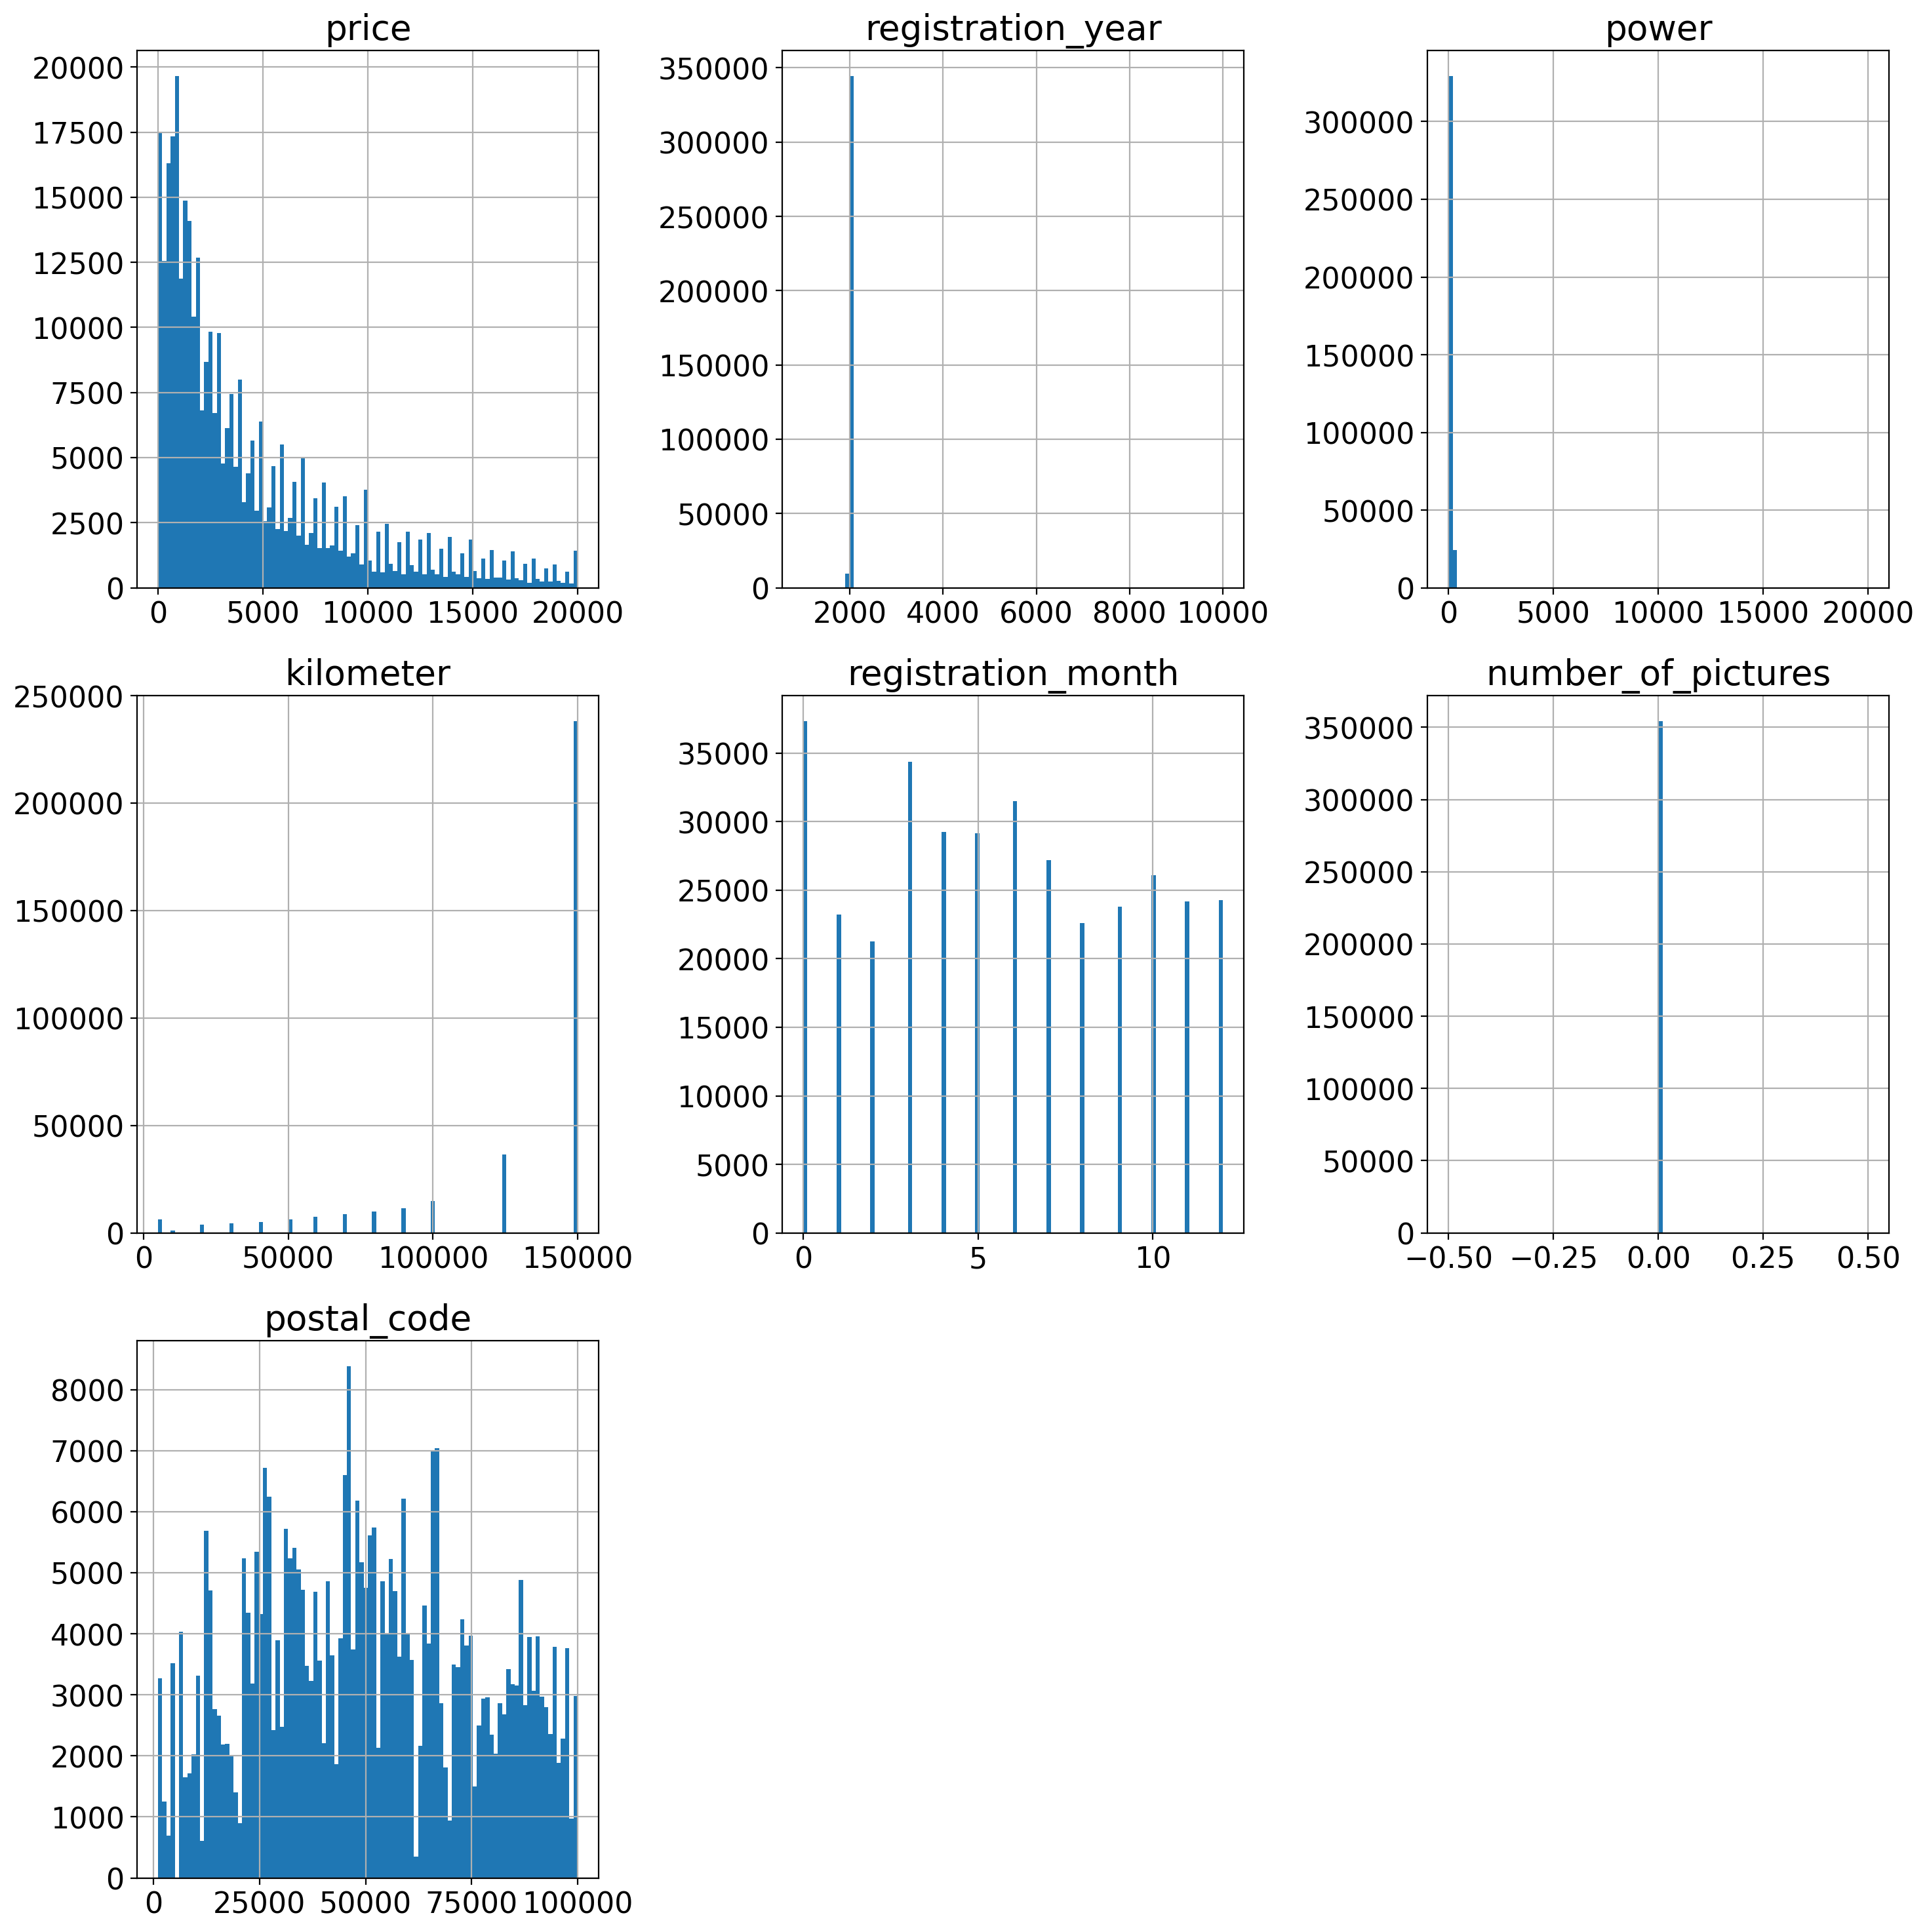

In [7]:
df_raw.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

Отсюда для себя выделяем столбцы **registration_year, registration_month, power** и **number_of_pictures**, они требуют дополнительного исследования. Расмотрим также и статистические показатели:

In [8]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Как видим, столбец **number_of_pictures** не информативный, поскольку содержит только одну константу для всех данных. Прежде чем исключать его из расчёта сначала необходимо исключить полные дубликаты из всего фрейма данных.

In [9]:
df_raw.duplicated().sum()

4

Также взглянем на корреляцию в данных, со значениями по модулю большими чем 0.2:

In [10]:
df_raw.corr(numeric_only=True)\
.where(lambda x: (abs(x) >= .2) & (abs(x) < 1)).stack()

price      kilometer   -0.333199
kilometer  price       -0.333199
dtype: float64

Сравним полученные результаты с анализом библиотеки phik:

In [11]:
main_cols = ['price', 'registration_year', 'power',
             'kilometer', 'postal_code', 'registration_month']
phik_overview = df_raw[main_cols].phik_matrix(interval_cols=main_cols)
phik_overview.where(lambda x: (abs(x) >= .2) & (abs(x) < 1)).stack()

price              kilometer            0.310844
registration_year  kilometer            0.230438
kilometer          price                0.310844
                   registration_year    0.230438
dtype: float64

На основании описания данных, информации из метода info(), а также визуальных и статистических данных можно заключить, что часть столбцов не несёт в себе полезной информации и её можно исключить из дальнейших расчётов. Также удалим из него дубликаты и строки, в которых пропусков больше 3.

Данные касающиеся анкеты пользователя с большой уверенностью не влияют на цену автомобилей, как и месяц, в котором они были зарегистрированы, у всех автомобилей отсутствуют фотографии.

Если взглянуть также на даты из столбцов с датами, то можно заметить, что все даты сосредоточены около 2016 года, а значит автомобили с годом регистрациии больше 2016 можно считать невалидными.

- DateCrawled: первая - 2016-03-24 11:52:17, последняя - 2016-04-07 03:16:57 
- DateCreated: первая - 2016-03-24, последняя - 2016-04-07 
- LastSeen: первая - 2016-03-17 17:40:17, последняя - 2016-04-07 03:16:57

In [12]:
thresh_cols = ['number_of_pictures', 'date_crawled', 'last_seen',
               'date_created', 'registration_month', 'postal_code']
df = (df_raw.drop_duplicates()
    .reset_index(drop=True)
    .drop(columns=thresh_cols)
    .dropna(thresh=len(df_raw.columns) - len(thresh_cols) - 3)
).copy()
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354360,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Обработка качественных данных

Касательно оставшихся данных можно сказать следующее:

- **vehicle_type** - кабриолет или автомобиль класса люкс могут иметь более высокую цену, чем седан или хэтчбек;
- **registration_year** — новые автомобили или автомобили с недавним годом регистрации, как правило, стоят дороже, чем старые автомобили, если это не раритет из ограниченной серии;
- **gearbox** - автоматические коробки передач, как правило, дороже, чем механические;
- **power** - автомобили с большей мощностью, как правило, дороже, чем автомобили с меньшей мощностью;
- **model** - некоторые модели автомобилей дороже других. Например, модели класса люкс или спорткары могут стоить дороже, чем модели эконом-класса;
- **kilometer** - автомобили с большим пробегом дешевле, чем автомобили с меньшим пробегом;
- **fuel_type** - электромобили или гибридные автомобили могут иметь более высокую цену, чем традиционные автомобили с бензиновым двигателем;
- **brand** - люксовые бренды, такие как Mercedes или BMW, могут иметь более высокую цену, чем экономичные бренды, такие как Ford или Honda;
- **repaired** - автомобили, которые были в ремонте, обычно дешевле, чем новенькие модели недавнего производства.

Теперь, когда данные немного предобработаны, следует более детально взглянуть на каждый столбец, чтобы оценить в них пропуски, аномалии, ошибки и подготовить данные к дальнейшей работе с моделями.

In [13]:
def column_stats(col, df=df):
    
    if df[col].dtype == 'object':
        if col not in ['model', 'brand']:
            plt.figure(figsize=(12, 8))
            ax = sns.countplot(x=col, data=df, palette='PuBuGn')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            plt.title('Столбчатая диаграмма для колонки ' + col)
            plt.show()
        print('Основные статистические данные:\n')
        print(df[col].describe())
    else:

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        sns.histplot(data=df, x=col, ax=ax1, kde=True)
        ax1.set_title('Гистограмма для колонки ' + col)
        sns.boxplot(data=df, x=col, ax=ax2)
        ax2.set_title('Boxplot для колонки ' + col)
        ax2.set_xlabel('Диапазон значений')
        ax2.set_ylabel(col)
        ax2.minorticks_on()
        plt.tight_layout()
        plt.show()
        print('Основные статистические данные:\n')
        print(df[col].describe(percentiles=[.05, .25, .75, .95]).round(2))
        print('\nКол-во уникальных значений в столбце:', df[col].nunique())
        
    print('Список уникальных значений:',
          df[col].unique() if df[col].dtype == 'object' else 
          np.sort(df[col].unique())) 
    print('Доля пропусков:', df[col].isna().mean())

Начём изучение данных по порядку:

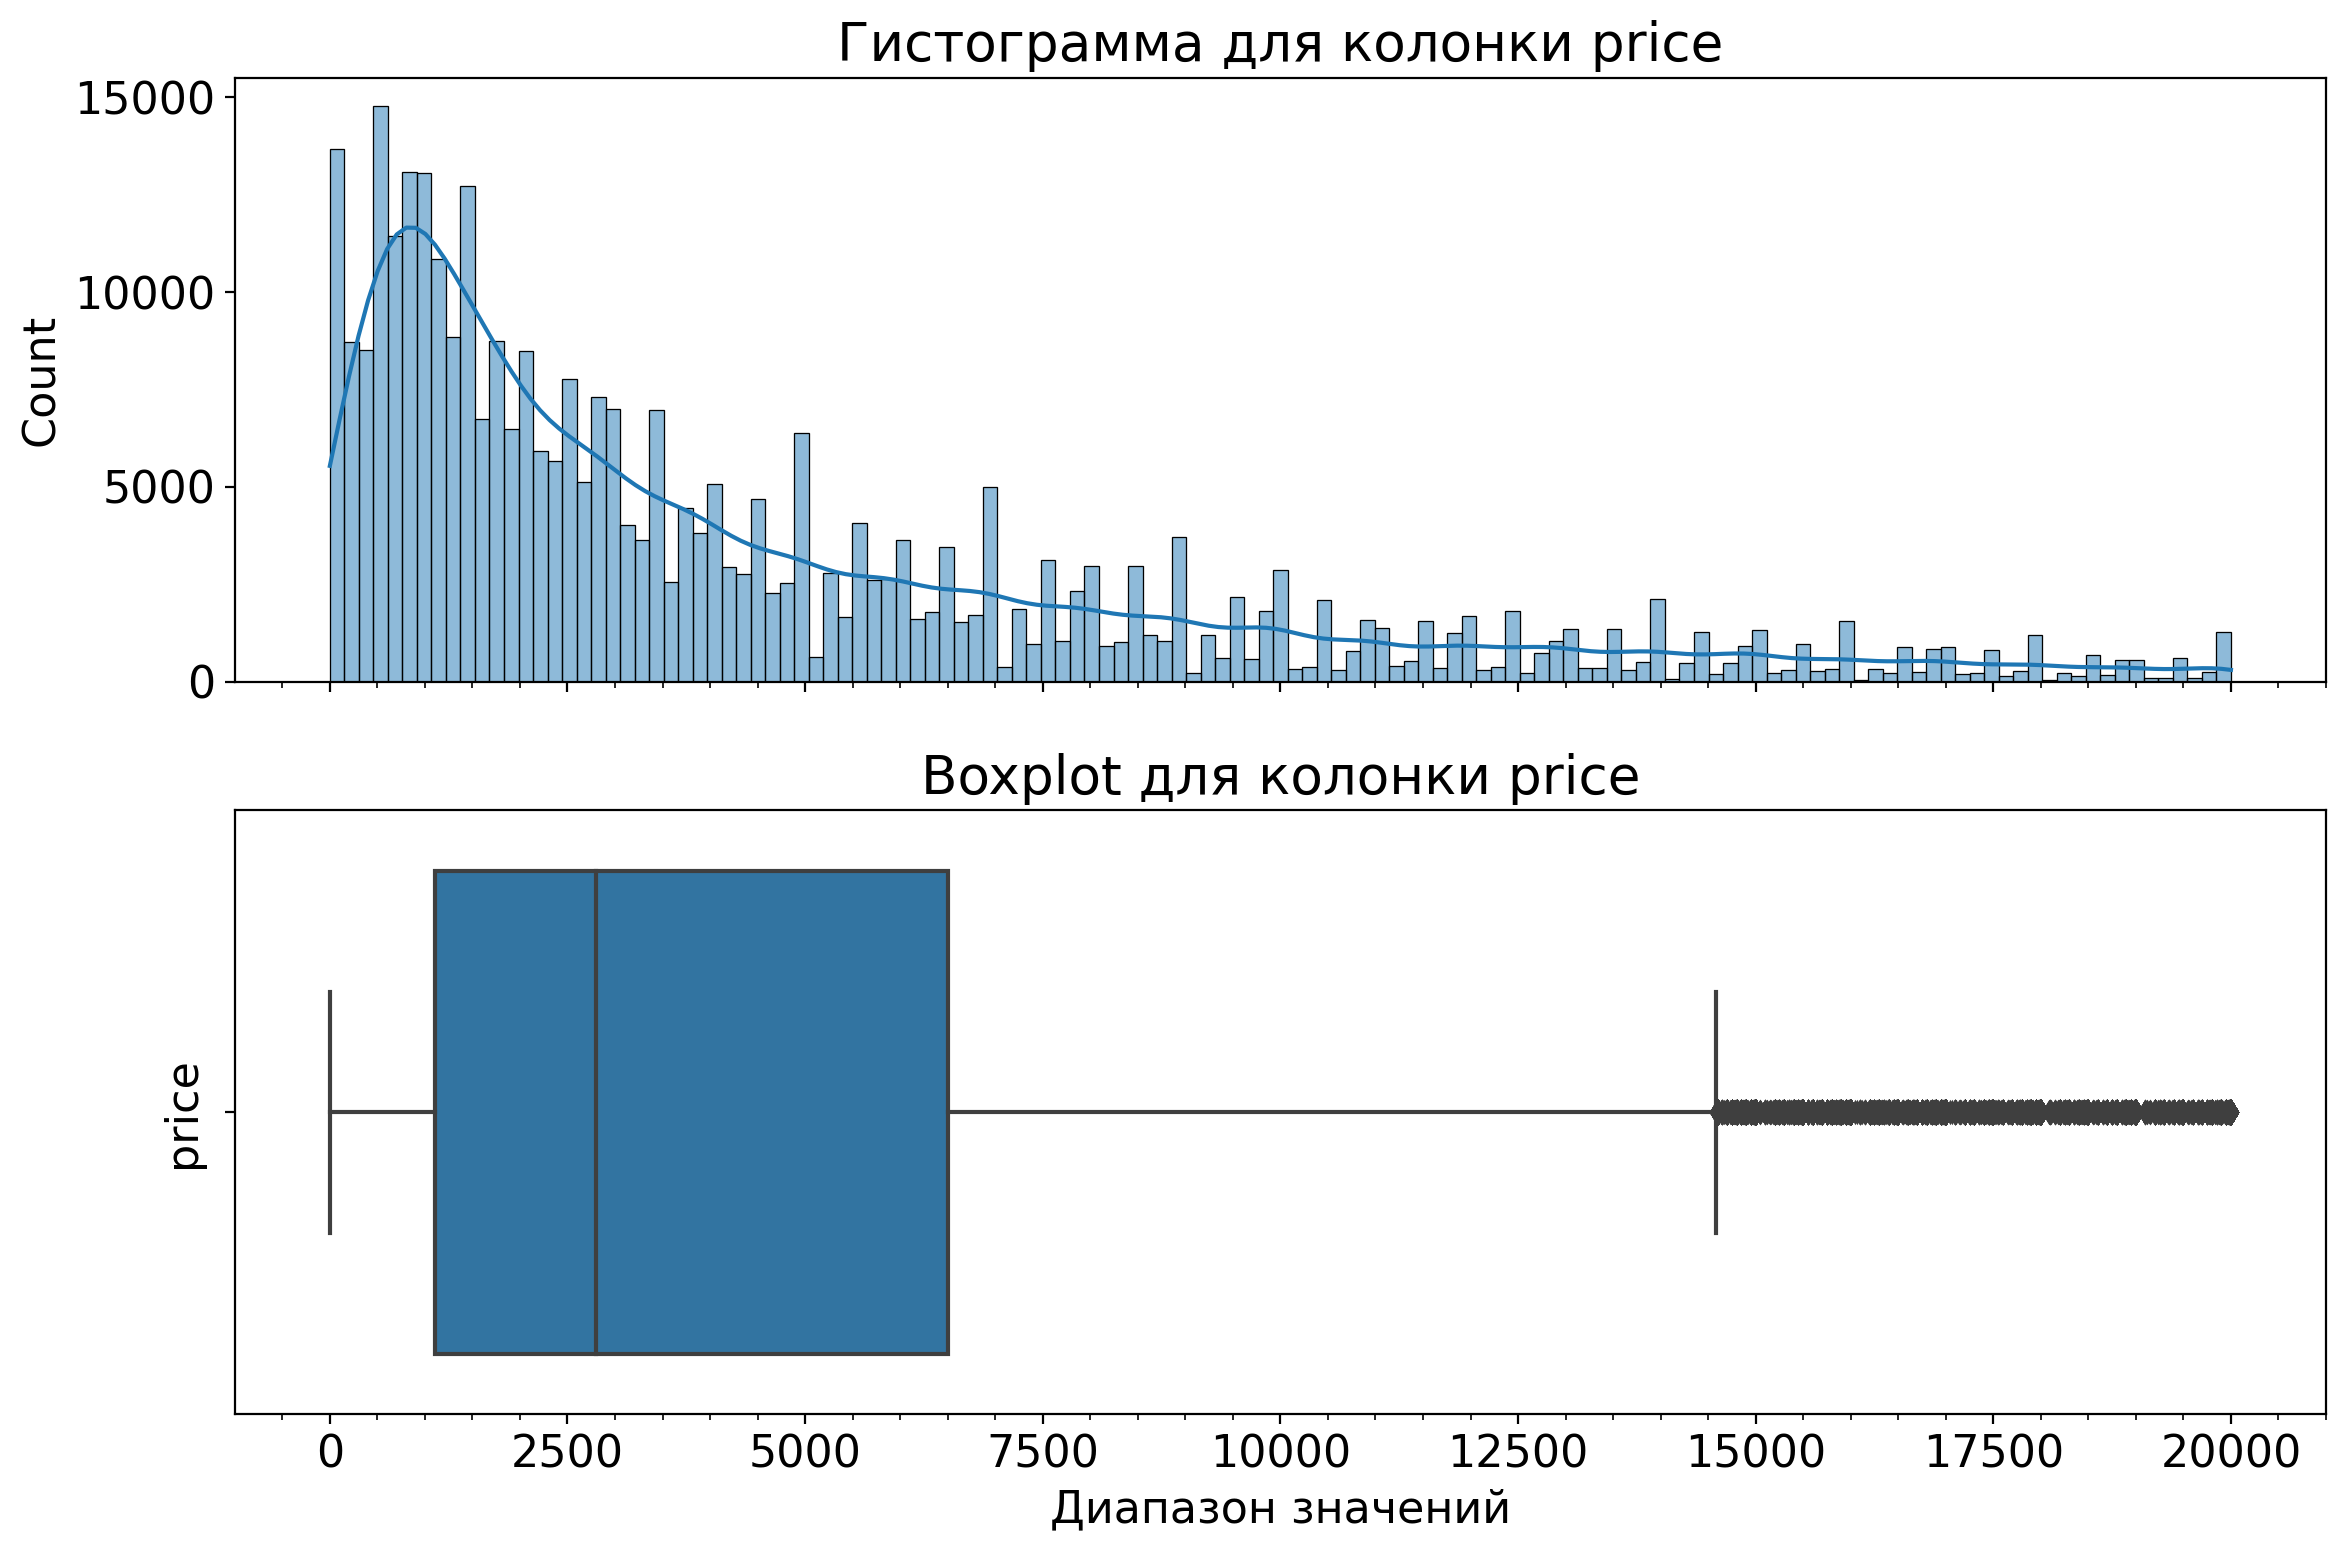

Основные статистические данные:

count    346345.00
mean       4485.15
std        4525.07
min           0.00
5%          250.00
25%        1111.00
50%        2800.00
75%        6500.00
95%       14750.00
max       20000.00
Name: price, dtype: float64

Кол-во уникальных значений в столбце: 3705
Список уникальных значений: [    0     1     2 ... 19998 19999 20000]
Доля пропусков: 0.0


In [14]:
column_stats('price')

В общем случае, продавец вправе выставлять на автомобиль любую цену, но с точки зрения моделирования такой результат не будет ясно отражать реальное положение дел, поэтому в качестве нижней оценки цены оставим хотя бы 450 евро.

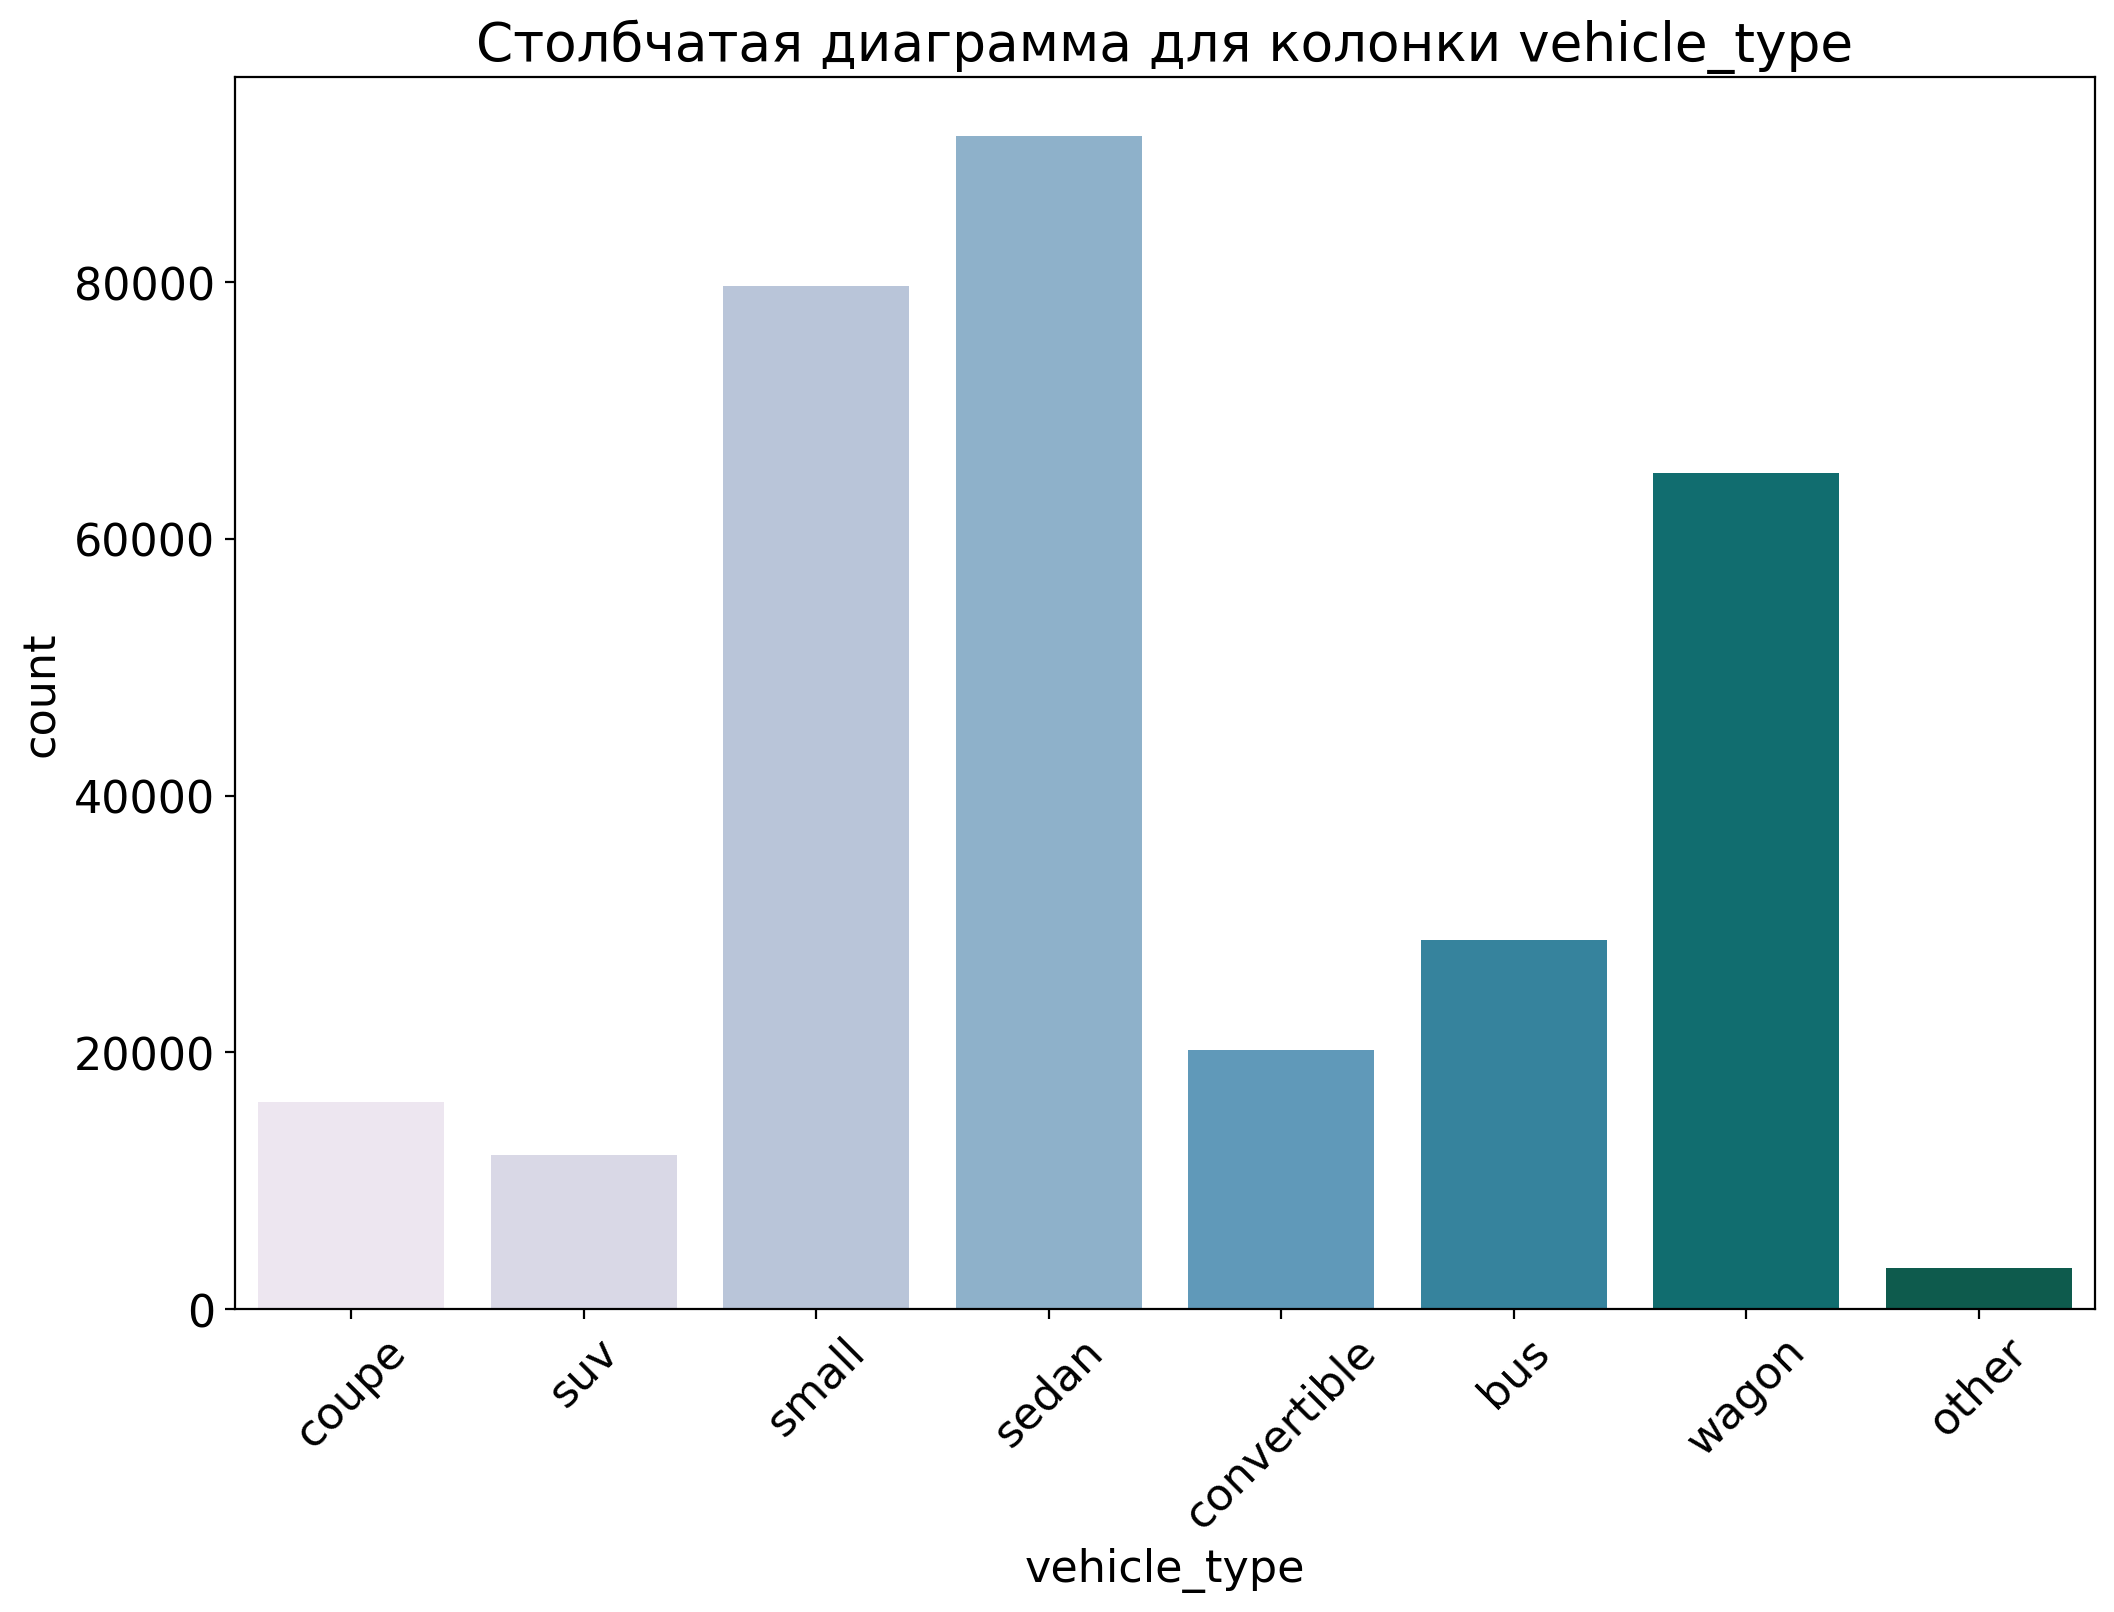

Основные статистические данные:

count     316516
unique         8
top        sedan
freq       91391
Name: vehicle_type, dtype: object
Список уникальных значений: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Доля пропусков: 0.08612510646898323


In [15]:
column_stats('vehicle_type')

В данной колонке нет ничего необычного, кроме наличия пропусков, которые можно либо отнести в класс 'other', либо пометить отдельной категорией 'missing' в дальнейшем.

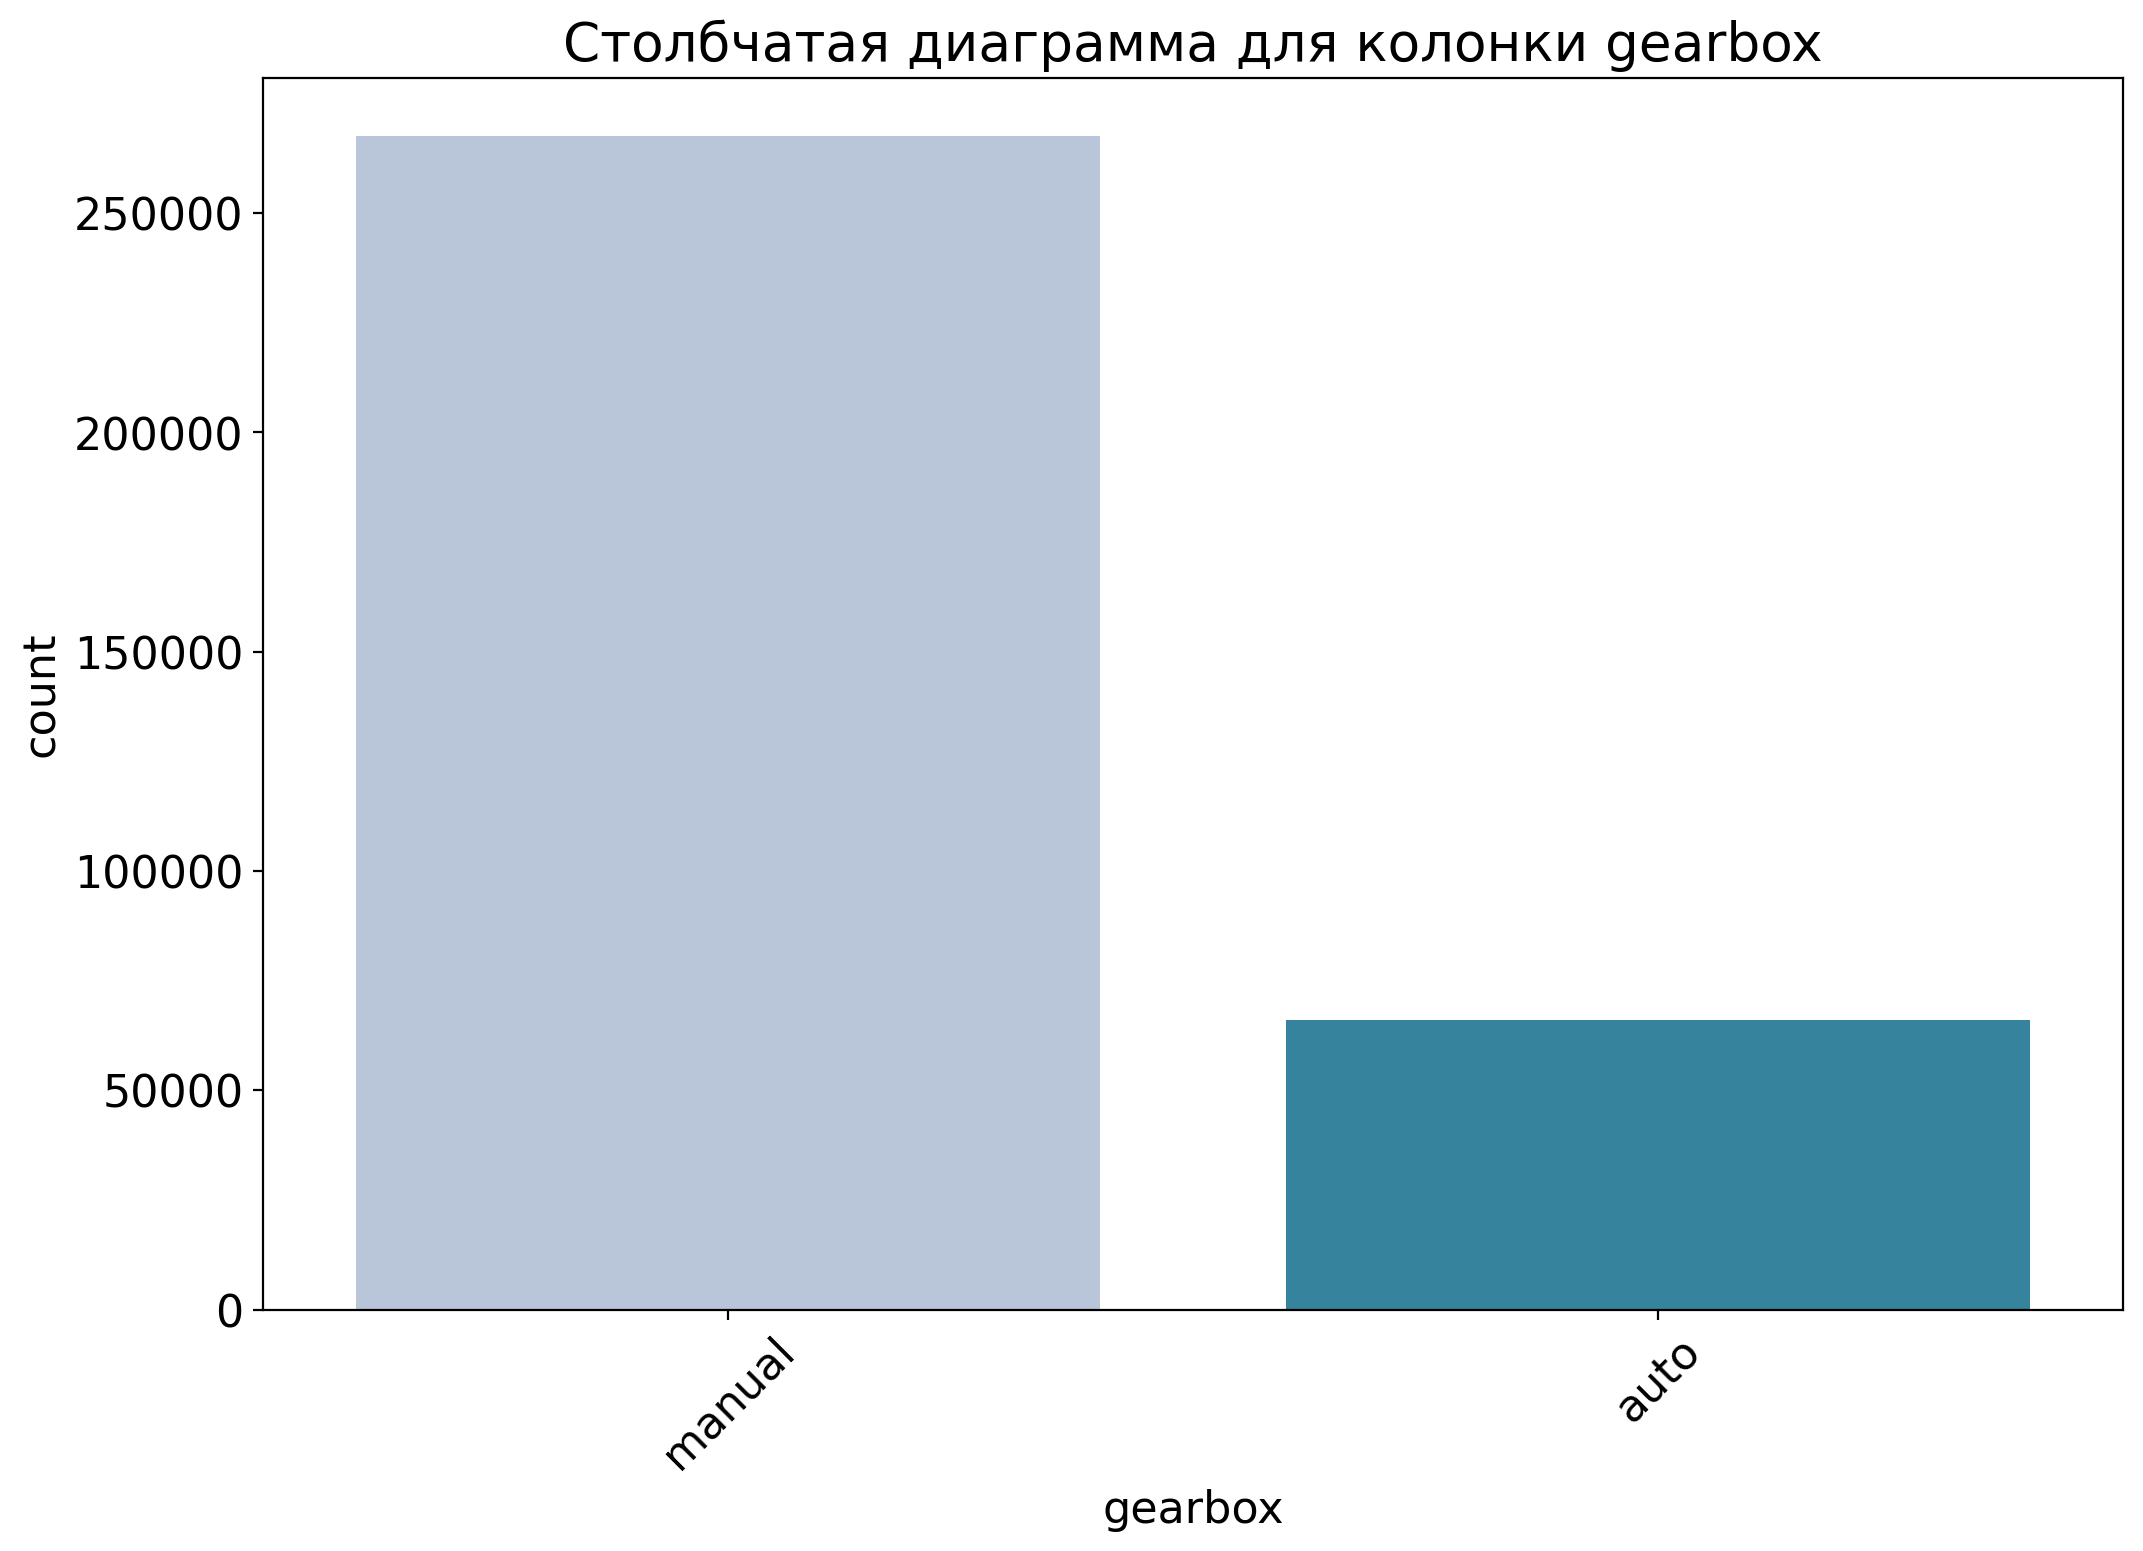

Основные статистические данные:

count     333681
unique         2
top       manual
freq      267549
Name: gearbox, dtype: object
Список уникальных значений: ['manual' 'auto' nan]
Доля пропусков: 0.03656469705062871


In [16]:
column_stats('gearbox')

В колонке gearbox пропуски затем заполним с помощью 'missing'.

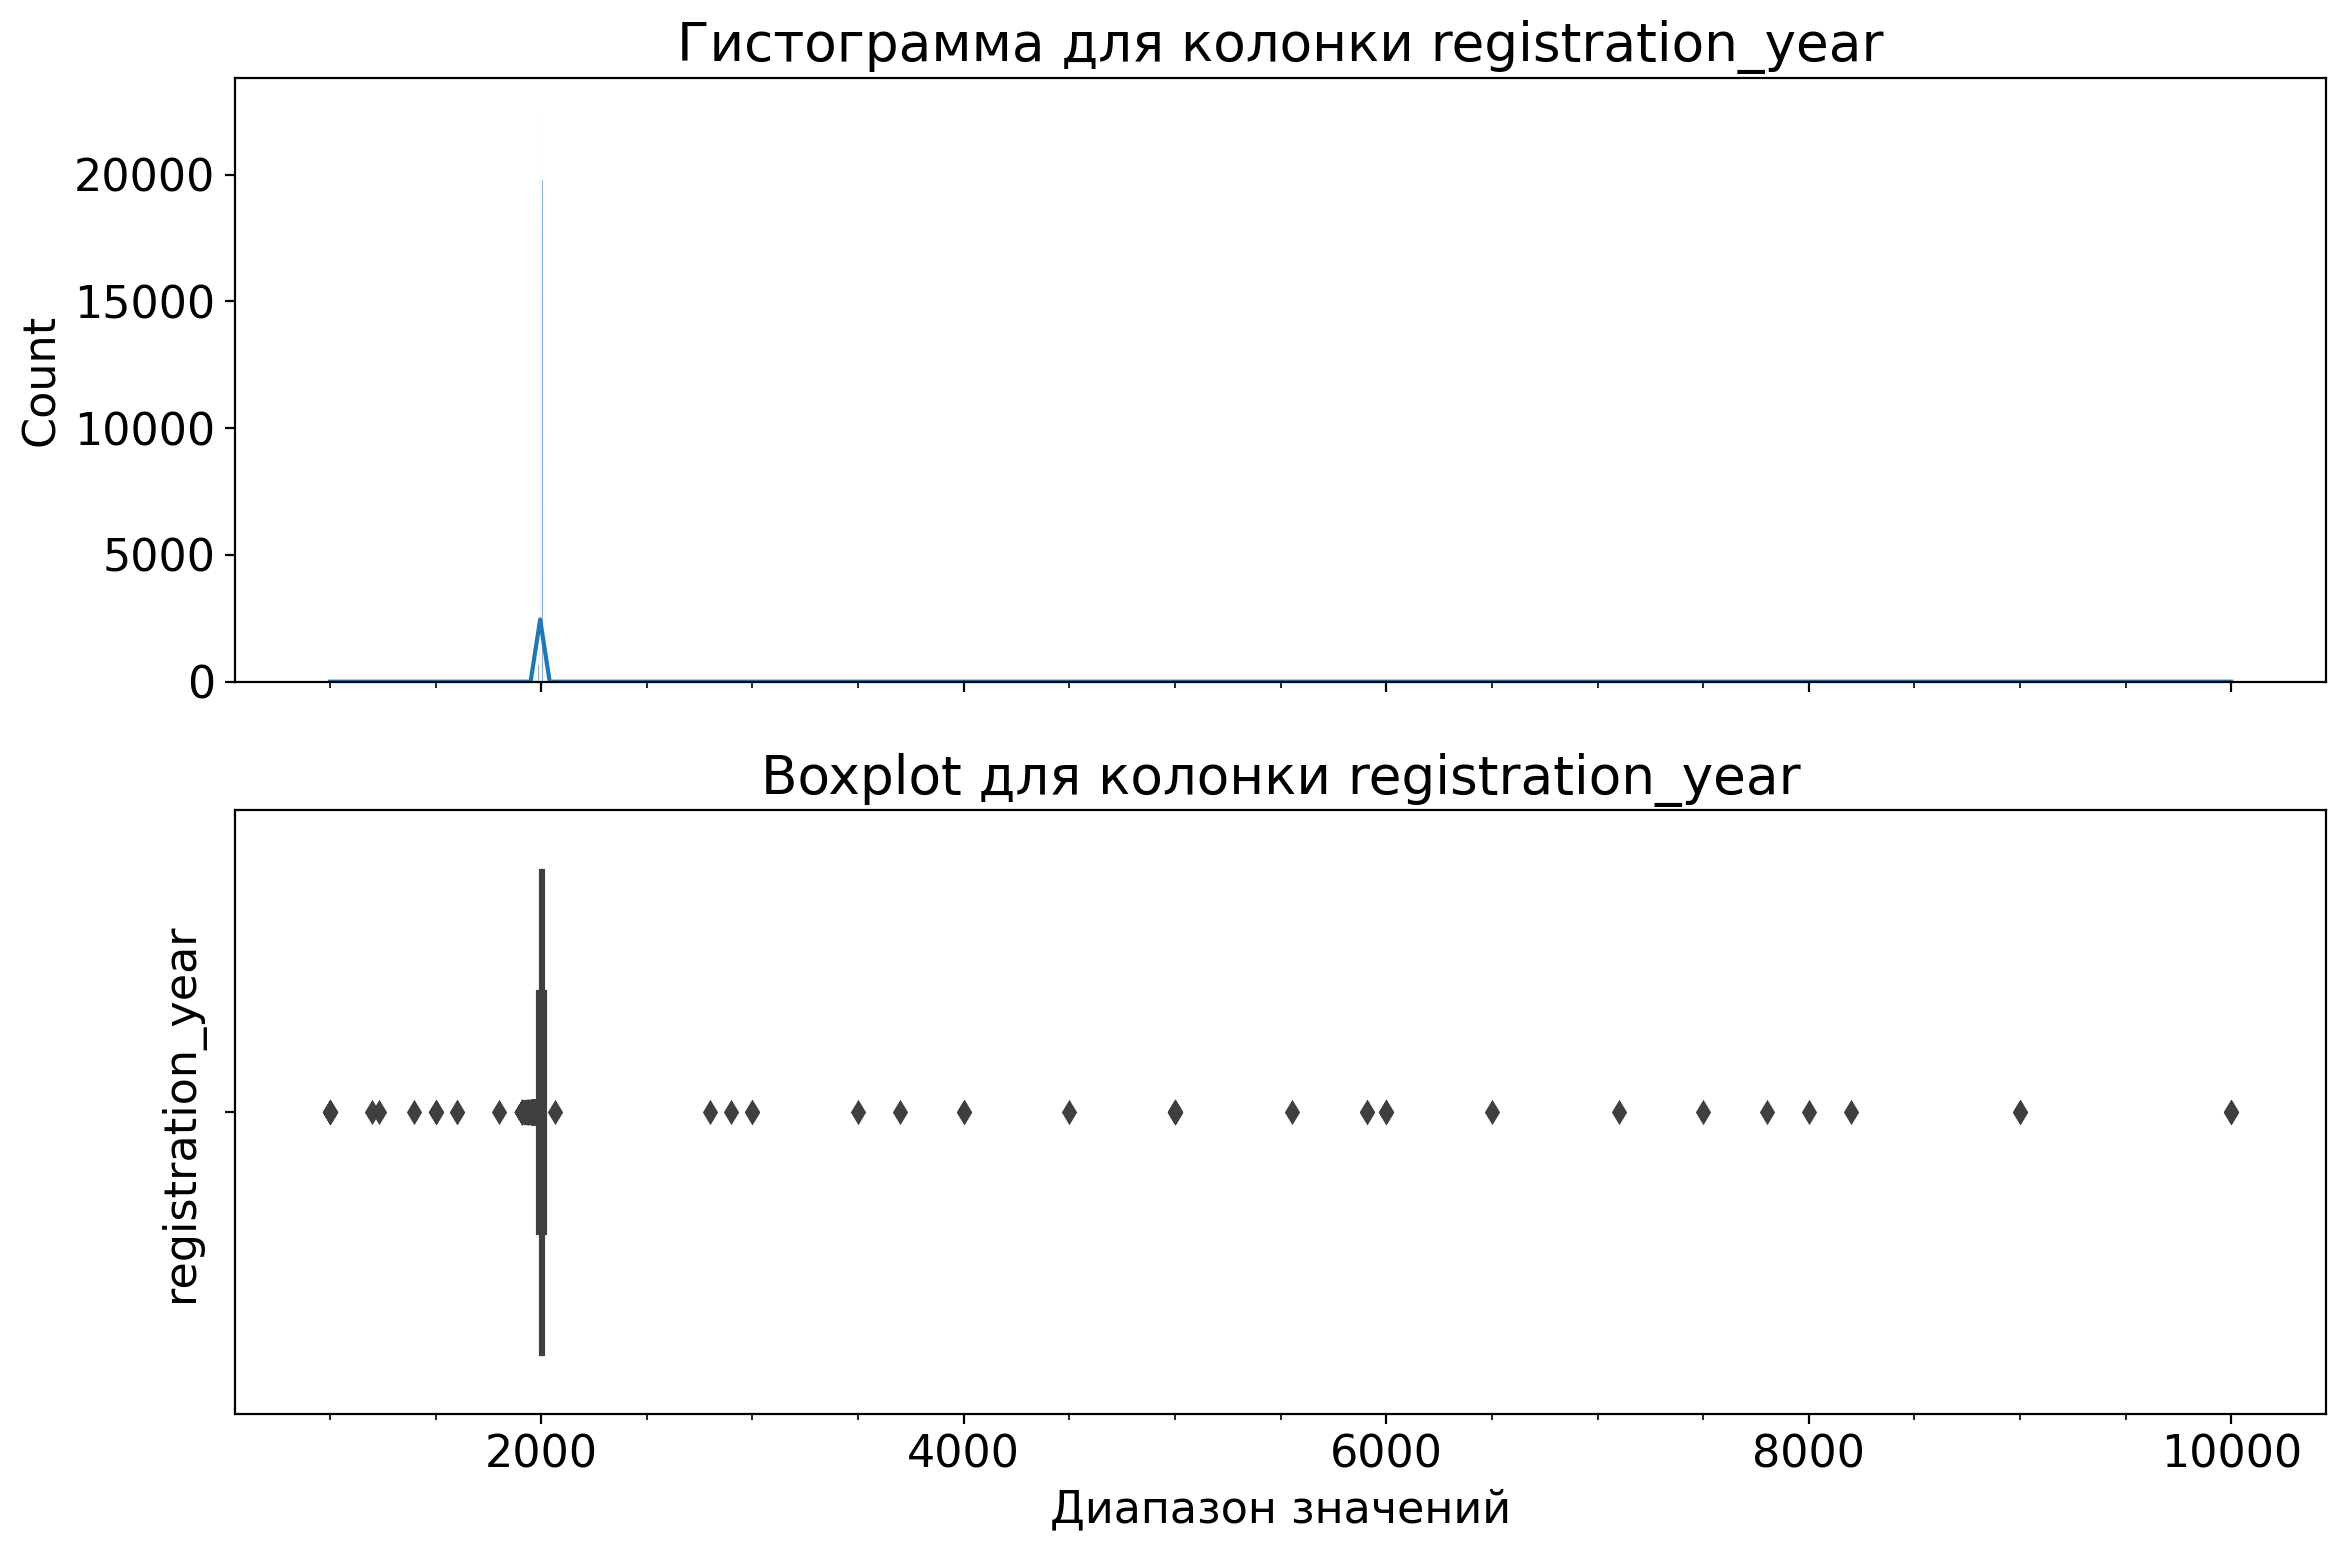

Основные статистические данные:

count    346345.00
mean       2003.48
std          44.83
min        1000.00
5%         1993.00
25%        1999.00
50%        2003.00
75%        2008.00
95%        2016.00
max        9999.00
Name: registration_year, dtype: float64

Кол-во уникальных значений в столбце: 125
Список уникальных значений: [1000 1200 1234 1400 1500 1600 1602 1800 1910 1919 1920 1923 1925 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940 1941 1942
 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2066 2800 2900 3000 3500 3700 4000
 4500 5000 5555 5911 6000 6500 7100 7500 7800 8000 8200 9000 9999]
Доля пропусков: 0.0


In [17]:
column_stats('registration_year')

Box plot в данном случае более наглядный и позволяет различить много аномалий, но в валидный диапазон значений пожалуй стоит выделить года с 1900 по 2016, поскольку большая часть объявлений датируется 16 годом.

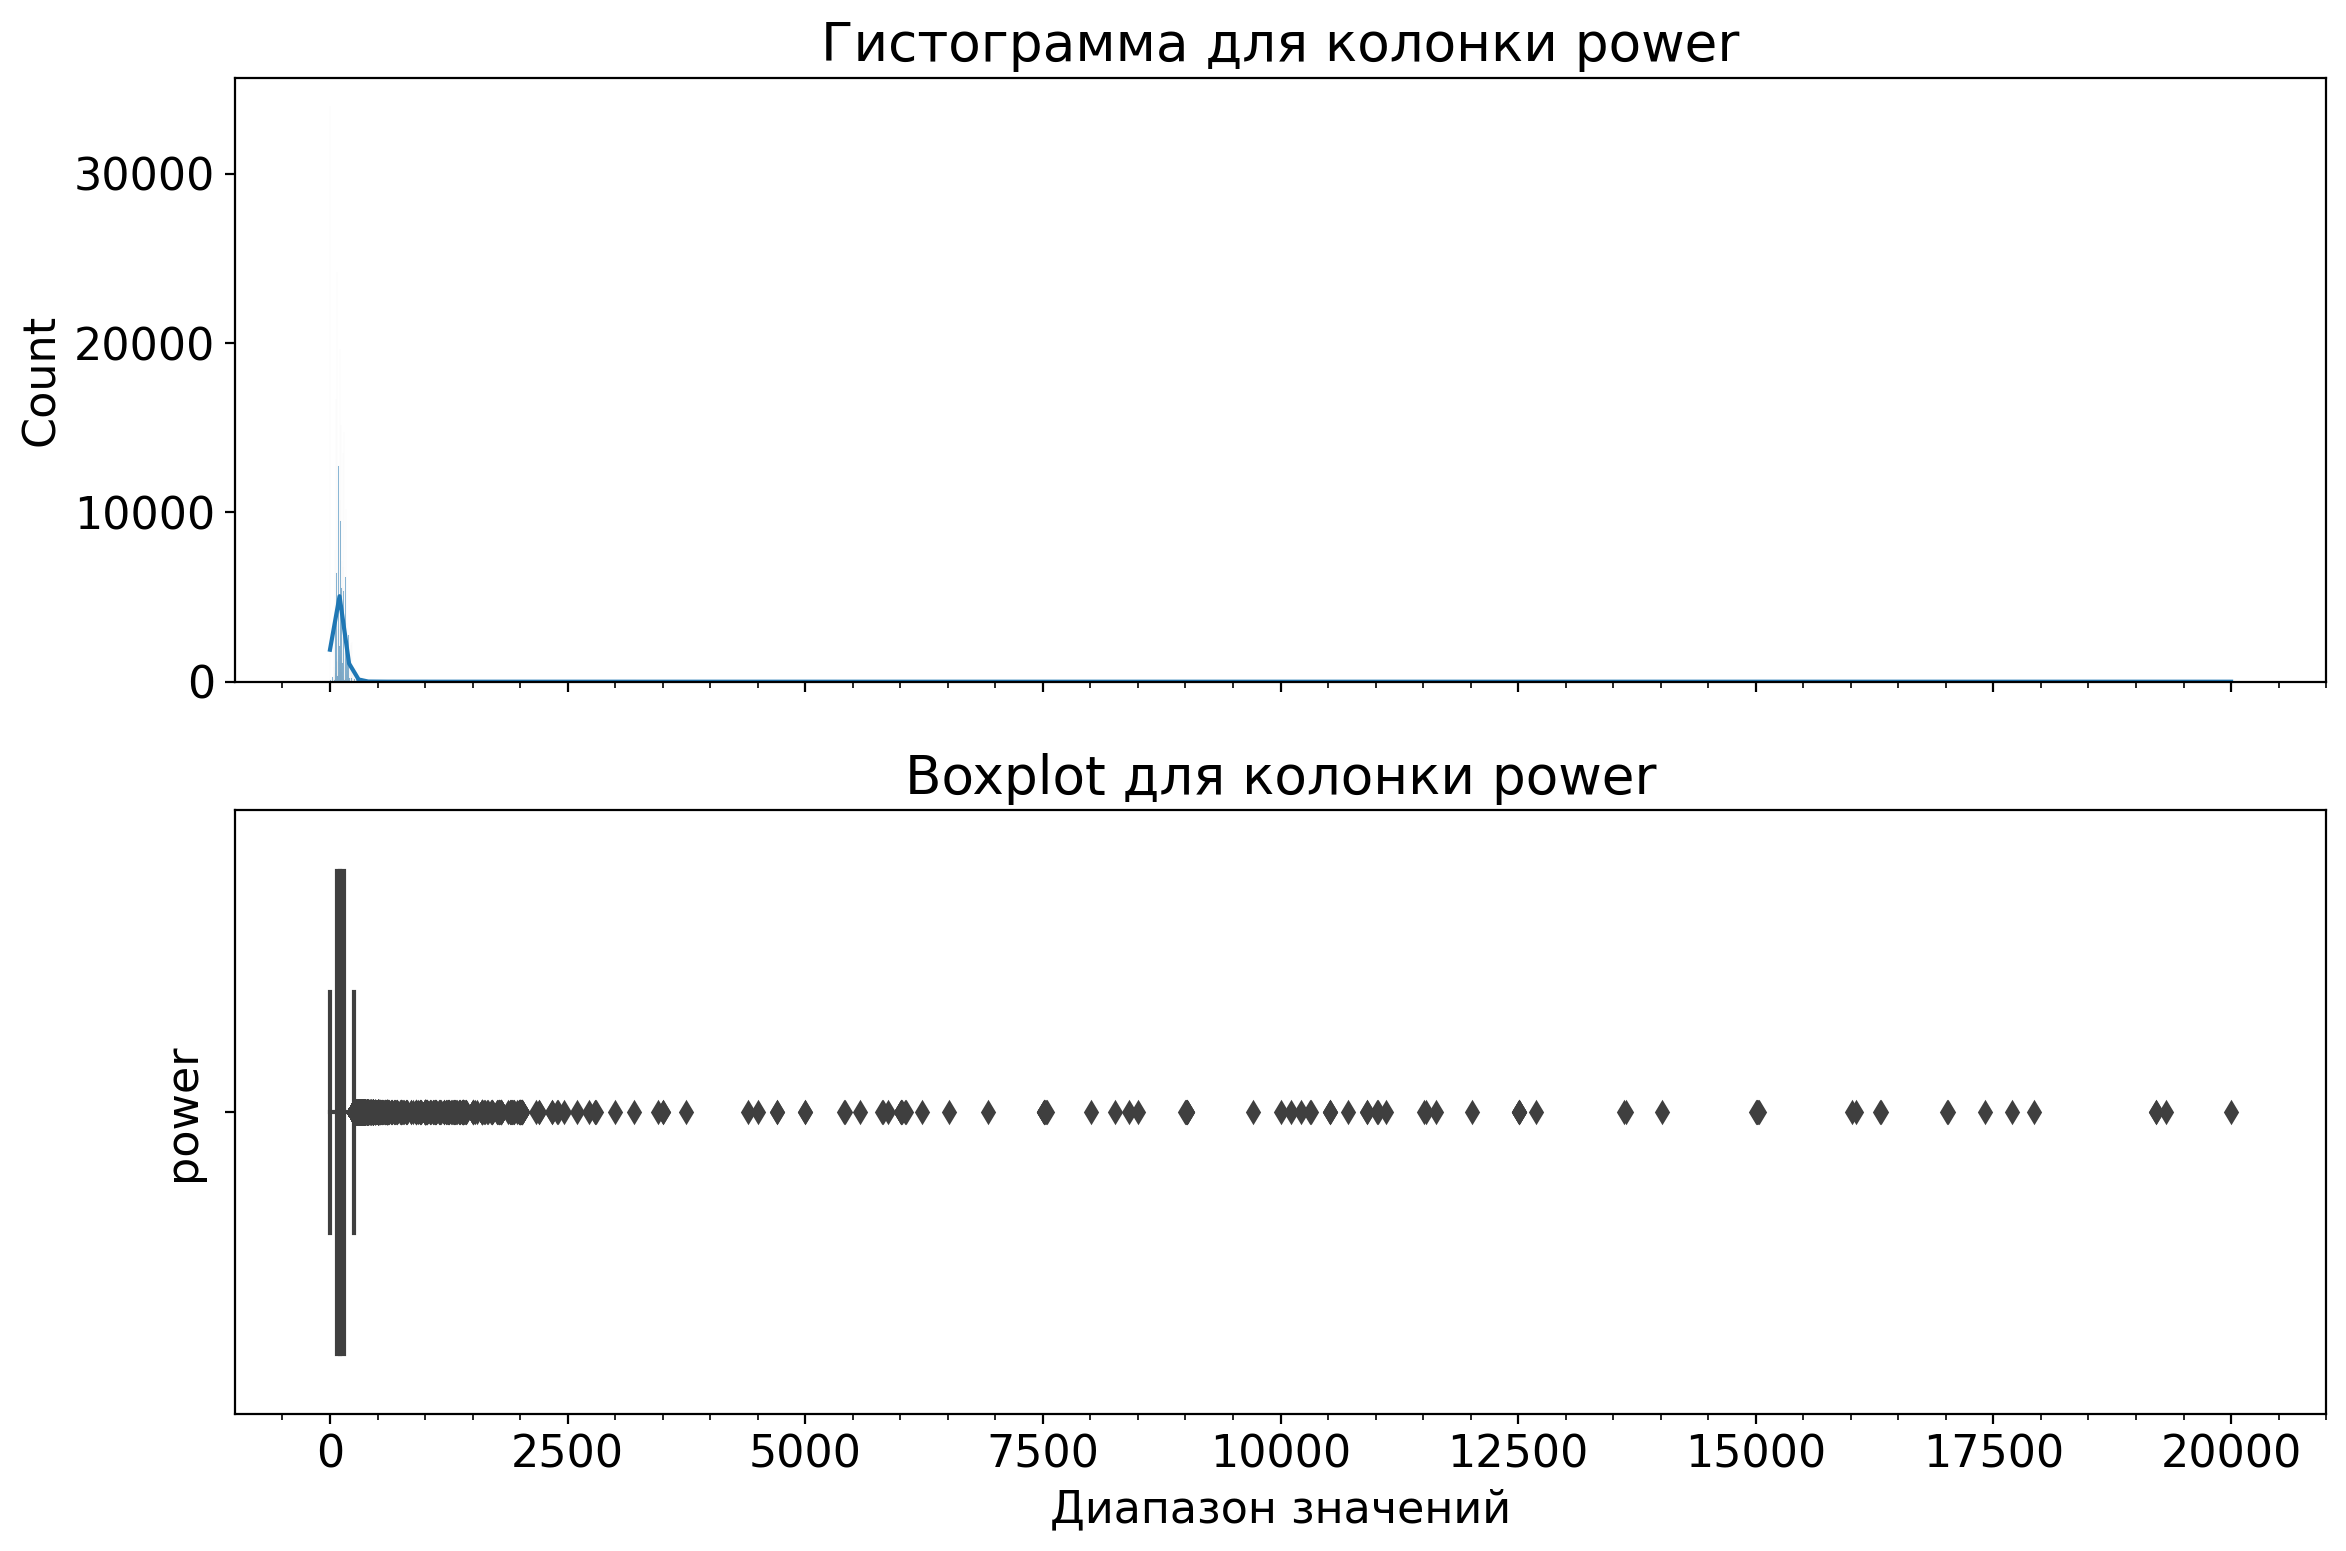

Основные статистические данные:

count    346345.00
mean        112.07
std         191.29
min           0.00
5%            0.00
25%          71.00
50%         105.00
75%         143.00
95%         218.00
max       20000.00
Name: power, dtype: float64

Кол-во уникальных значений в столбце: 709
Список уникальных значений: [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   

In [18]:
column_stats('power')

Хоть пропусков и нет однако аномальных значений здесь в избытке(20000 л.с это явно слишком много, современные автомобили находятся в промежутке от 30-40 до 300 л.с), но учитывая широкие временные рамки, а значит и наличие совсем слабых авто, ограничимся значениями с 1 до 500 л.с.

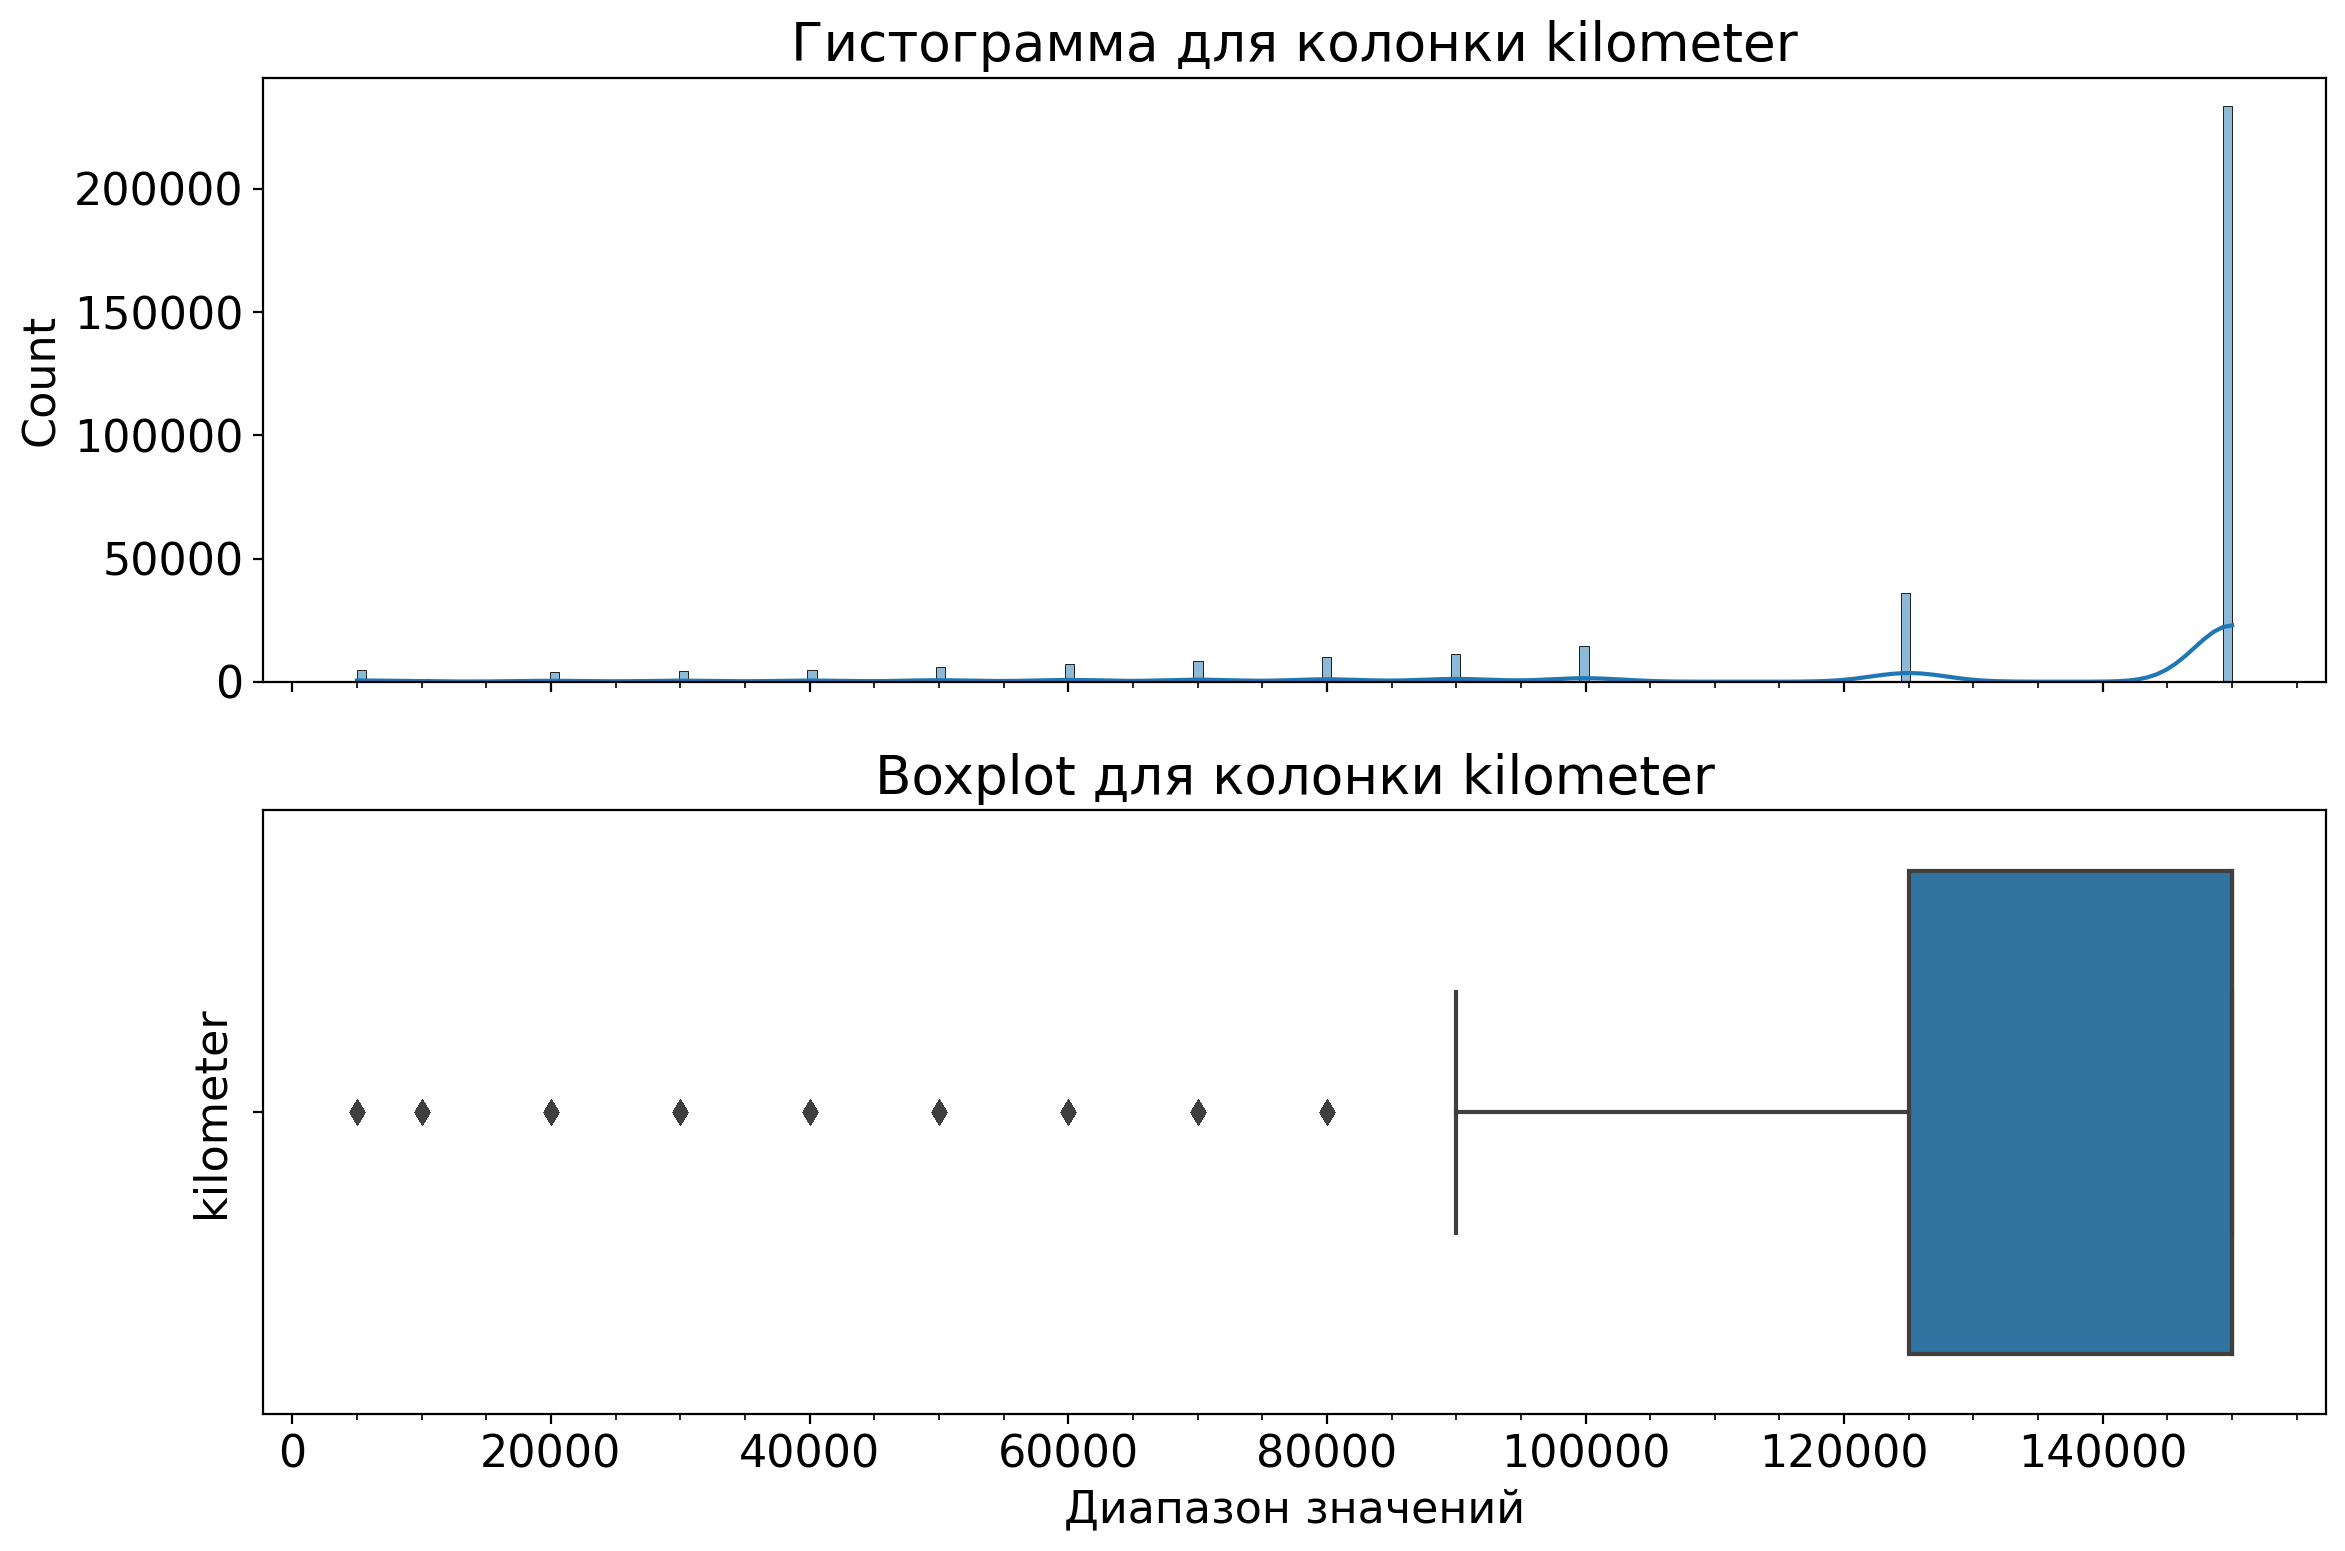

Основные статистические данные:

count    346345.00
mean     128704.10
std       37101.46
min        5000.00
5%        40000.00
25%      125000.00
50%      150000.00
75%      150000.00
95%      150000.00
max      150000.00
Name: kilometer, dtype: float64

Кол-во уникальных значений в столбце: 13
Список уникальных значений: [  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]
Доля пропусков: 0.0


In [19]:
column_stats('kilometer')

В данном столбце тоже нет ничего особенного, ведь на автомобиле можно накатать как много километров, так и мало, а малые значения характерны либо для совсем новых, либо для антикварных автомобилей.

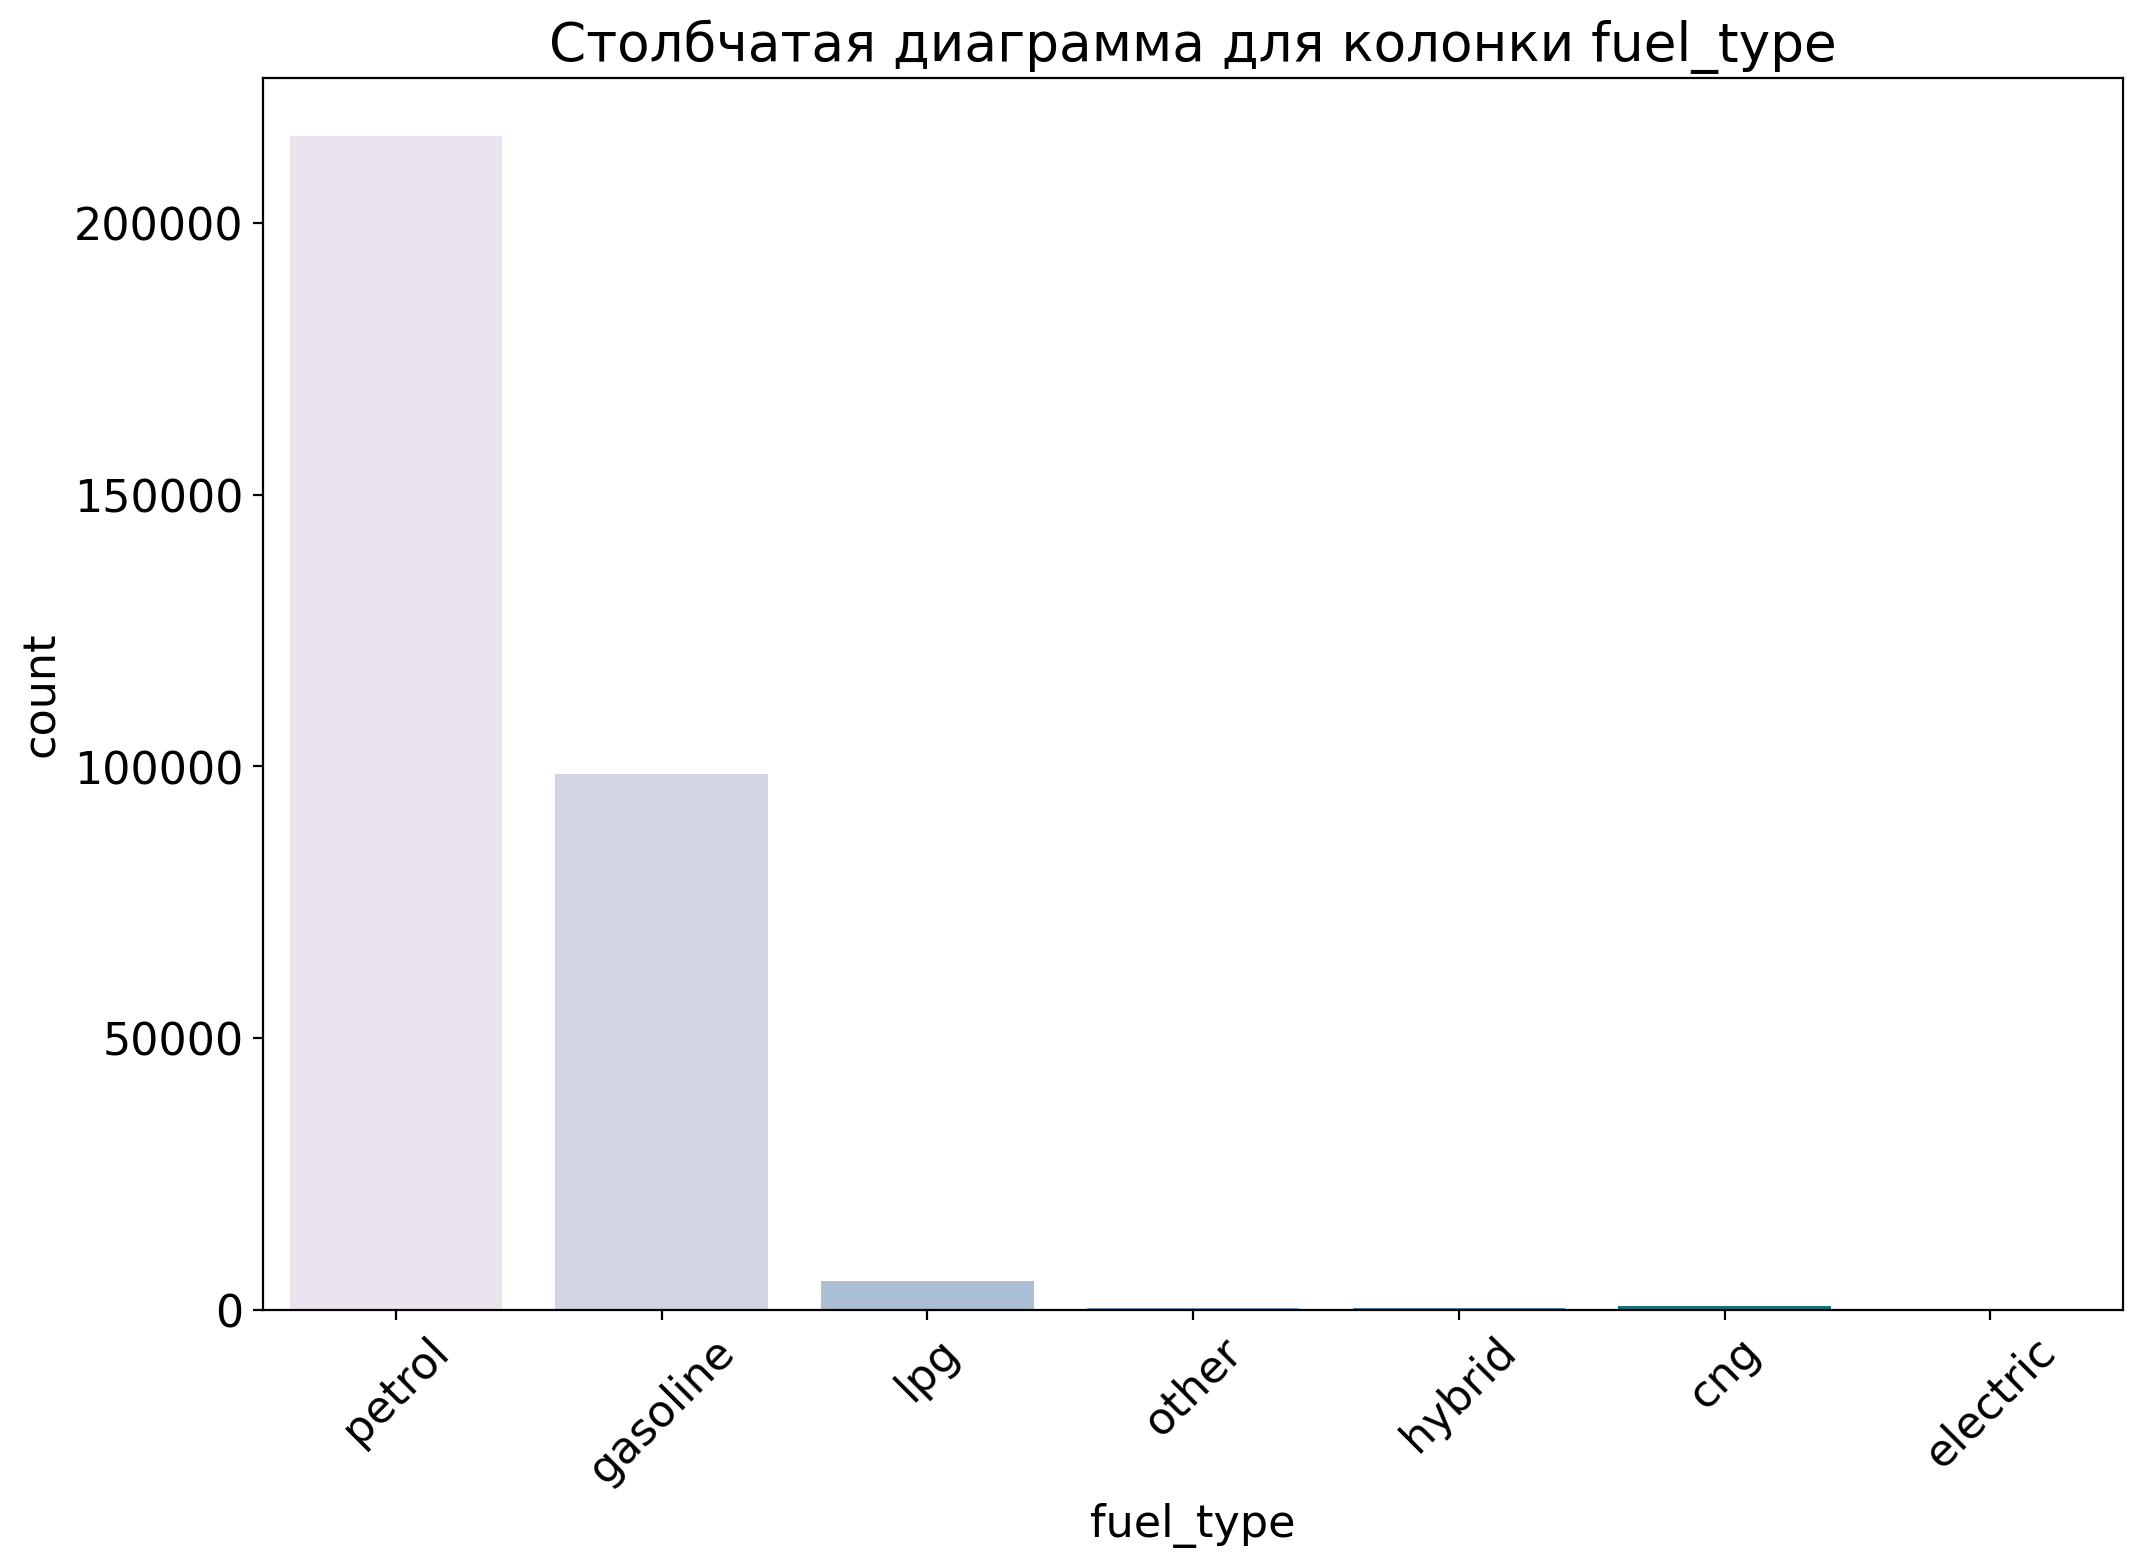

Основные статистические данные:

count     321026
unique         7
top       petrol
freq      216040
Name: fuel_type, dtype: object
Список уникальных значений: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Доля пропусков: 0.0731034084511109


In [20]:
column_stats('fuel_type')

Как видим стандартные типы топлива составляют самый большой набор значений, но в остальном пропуски можно также заполнить отдельным классом.

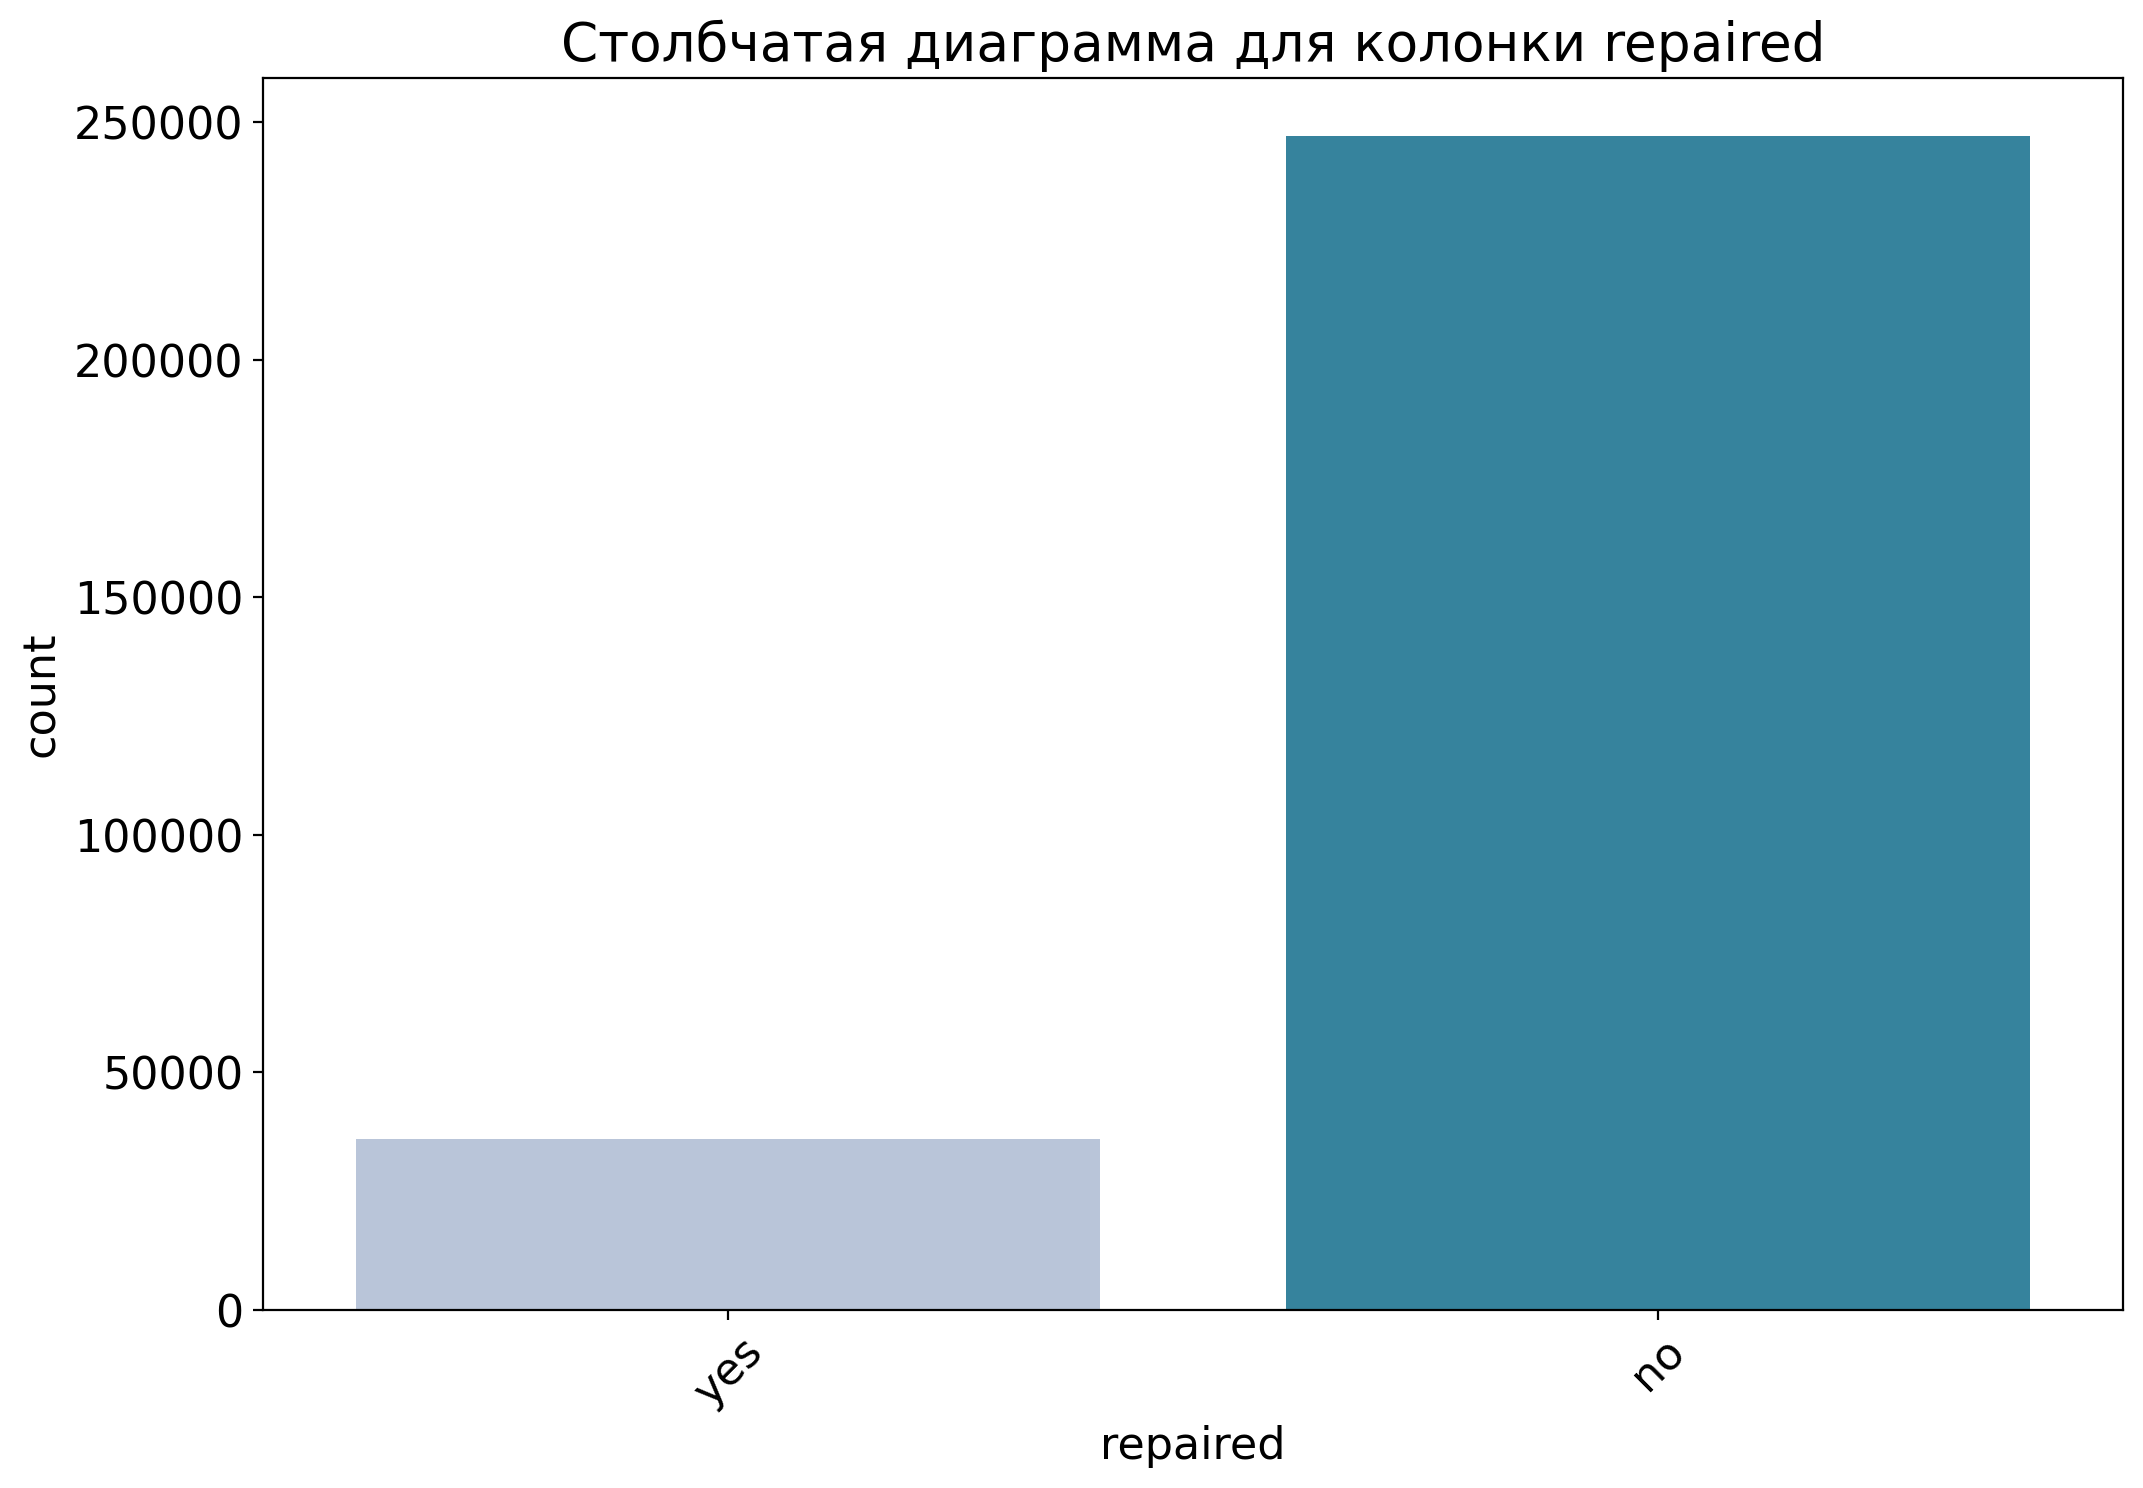

Основные статистические данные:

count     283056
unique         2
top           no
freq      247054
Name: repaired, dtype: object
Список уникальных значений: [nan 'yes' 'no']
Доля пропусков: 0.18273397912486106


In [21]:
column_stats('repaired')

Repaired также будет заполнена значением 'missing'

Поскольку данные в столбцах 'model' и 'brand' Имеют большое количество уникальных значений, то выводить их графиком нецелесообразно.

In [22]:
column_stats('brand')

Основные статистические данные:

count         346345
unique            40
top       volkswagen
freq           75184
Name: brand, dtype: object
Список уникальных значений: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche' 'rover'
 'land_rover' 'trabant' 'lada']
Доля пропусков: 0.0


In [23]:
column_stats('model')

Основные статистические данные:

count     330686
unique       250
top         golf
freq       28805
Name: model, dtype: object
Список уникальных значений: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'insignia' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio'

Пропуски в моделях можно заполнить как значением 'other', так и указанным ранее способом.

Промежуточные итоги следующие: пропуски имеются в 5 категориальных столбцах ('vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'), а аномалии в данных - в 3-х ('price', 'registration_year', 'power'). На первом шаге мы удалим аномалии, чтобы не заполнять лишние данные в дальнейшем.

In [24]:
df[(df['price'] > 450) & (df['registration_year'].between(1900, 2016)) & (df['power'].between(1, 500))]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354357,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354358,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [25]:
cond_1 = df['price'] > 450
cond_2 = df['registration_year'].between(1900, 2016)
cond_3 = df['power'].between(1, 500)
print(f'Удалено строк: {df.shape[0] - df[(cond_1) & (cond_2) & (cond_3)].shape[0]}')
df = df[(cond_1) & (cond_2) & (cond_3)].copy()

Удалено строк: 66785


**Вывод:**

- Удалено 6 неинформативных столбцов: 'number_of_pictures', 'date_crawled', 'last_seen', 'date_created', 'registration_month', 'postal_code';
- Все столбцы были изучены визуально или через статистические показатели на аномалии и ошибки;
- Аномалии содержались в столбцах 'price', 'registration_year', 'power' и были исключены из набора данных, предназначенного для дальнейшего обучения и проверки;
- В конечном итоге удалено 66 тыс строк, что достаточно много, однако таким образом качество итоговой модели должно кардинально улучшиться.

## Обучение моделей

Очищенные данные разделим на 3 части, обучающую, валидационную и тестовую выборку, в данном случае валидационная выборка послужит в качестве неизвестных данных, чтобы оценить для нужд заказчика скорость обучения моделей. Лучшая модель пройдёт исследование метрики на тестовой выборке.

In [26]:
X = df.drop('price', axis=1)
y = df['price']

In [27]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RND)

Дальнейшая обработка значений будет происходить в рамках пайплайна, и в первую очередь преобразованные данные будут поступать на вход модели:

- Числовые столбцы не требуют доп. обработки, они не искажены и рамках данной работы не были применены линейные модели;
- Категориальные признаки будут обработаны OrdinalEncoder'ом, поскольку большая часть моделей на основе деревьев и это не повлияет на конечный результат;
- Поскольку неинформативные столбцы уже удалены, остальные, если и останутся, то не будут преобразованы;
- DtypeOptimizer необходим, чтобы после преобразования данных в полностью числовые, сократить объём потребления памяти и ускорить исследование моделей;
- Далее трансформер объединяется с моделью + подобранными для неё распределениями гиперпараметров отправляется на этап оптимизации OptunaCV с кроссвалидацией cv=3, который вернёт лучшую модель;
- Собирается информация о скорости обучения на трейне и предсказания моделей на валидационной выборке;
- Формируется выходной массив данных для итогового исследования.

In [28]:
class DtypeOptimizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes('number').columns:
            min_val = X[col].min()
            max_val = X[col].max()
            if min_val >= 0:
                if max_val < np.iinfo(np.uint8).max:
                    X[col] = X[col].astype('uint8')
                elif max_val < np.iinfo(np.uint16).max:
                    X[col] = X[col].astype('uint16')
                elif max_val < np.iinfo(np.uint32).max:
                    X[col] = X[col].astype('uint32')
            
            elif (min_val >= np.iinfo(np.int8).min and
                  max_val < np.iinfo(np.int8).max):
                X[col] = X[col].astype('int8')
            elif (min_val >= np.iinfo(np.int16).min and
                  max_val < np.iinfo(np.int16).max):
                X[col] = X[col].astype('int16')
            elif (min_val >= -np.iinfo(np.int32).min and
                  max_val < np.iinfo(np.int32).max):
                X[col] = X[col].astype('int32')
        return X

In [29]:
# Словарь параметров, которые будут перебираться во время поиска лучшей модели
model_params = {
    'DecisionTreeRegressor': {
        'model__max_depth': IntDistribution(2, 30),
        'model__min_samples_split': IntDistribution(2, 5),
        'model__min_samples_leaf': IntDistribution(1, 5)
    },
    'KNeighborsRegressor': {
        'model__weights': CategoricalDistribution(['uniform', 'distance']),
        'model__n_neighbors': IntDistribution(2, 15)
    },
    'CatBoostRegressor': {
        'model__learning_rate': FloatDistribution(1e-3, 1e-1, log=True),
        'model__l2_leaf_reg': IntDistribution(1e0, 1e2, log=True)
    },
    'LGBMRegressor': {
        'model__max_depth': IntDistribution(100, 300, step=50),
        'model__learning_rate': FloatDistribution(0.001, 0.1, log=True),  
        'model__n_estimators': IntDistribution(100, 300, step=50)}
}
# Словарь непосредственно моделей
model_dict = {
    'CatBoostRegressor': CatBoostRegressor(random_seed=RND, verbose=0,
                                           early_stopping_rounds=300),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=RND,
                                                   ccp_alpha=.001),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'LGBMRegressor': LGBMRegressor(random_state=RND, verbose=0)
}

In [30]:
def pipeline_preparation(model, X):
    print('Подготовка данных...')
    # Отбираем числовые и категориаьные столбцы
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    # Создаём последовательную обработку категориальных переменных
    cat_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encode', ce.OrdinalEncoder())
    ])
    # Создаём обработчик для всех столбцов
    preprocessor = ColumnTransformer(transformers=[
        ('cat_prep', cat_transformer, cat_cols),
        ('num_prep', 'passthrough', num_cols)],
        remainder='passthrough'
    ).set_output(transform='pandas')
    
    print('Подготовка данных завершена!\n')
    # Возвращаем конвеер предобработки
    
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('memory_opt', DtypeOptimizer()),
                           ('model', model)])

def opt_hyperparametres_search(pipe, X, y, param):
    print('Поиск гиперпараметров...')
    # Создаём функцию для поиска гиперпараметров
    optuna_cv = OptunaSearchCV(
        pipe, 
        param, 
        n_trials=20, 
        scoring='neg_root_mean_squared_error',
        cv=3, 
        n_jobs=-1,
        random_state=RND
    )
    # Стключаем вывод итераций
    optuna.logging.set_verbosity(optuna.logging.FATAL)
    # Запускаем на обучающих данных
    optuna_cv.fit(X, y)
    print('Поиск гиперпараметров завершён!')
    
    return optuna_cv

def training_time(pipe, optimizer, X, X_new, y):
    print('Замер времени обучения...')
    # замер времени обучения пайплайна с лучшими параметрами
    start = time.perf_counter()
    best_model = pipe.set_params(**optimizer.best_params_).fit(X, y)
    model_train_time = time.perf_counter() - start

    print(f'Время обучения модели составило: {model_train_time} секунд\n')
    # замер времени предсказания пайплайна с лучшими параметрами
    start_p = time.perf_counter()
    best_model.predict(X_new)
    model_prediction_time = time.perf_counter() - start_p
    print(f'''Время предсказания модели составило: 
          {model_prediction_time} секунд\n''')
    return model_train_time, model_prediction_time


In [31]:
def model_analizer(model_name, X, y, models_params, models):
    X, y = X.copy(), y.copy()
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full, test_size=0.25, random_state=RND)
    
    param = models_params[model_name]
    model = models[model_name]
    
    print(f'Анализ модели {model_name}:')
    pipe = pipeline_preparation(model, X_train)
    best_model = opt_hyperparametres_search(pipe, X_train, y_train, param)
    model_train_time, model_predict_time = training_time(
        pipe, best_model, X_train, X_valid, y_train)
    print(f'Анализ модели {model_name} завершён!\n')
    model_best_params = best_model.best_params_
    model_best_score = -best_model.best_score_
    analiz_result = [best_model, model_name, model_best_params,
                     model_best_score, model_train_time, model_predict_time]
    return analiz_result

Блок исследования моделей:

In [32]:
analizer_params = {
    'X': X_train_full,
    'y': y_train_full,
    'models_params': model_params,
    'models': model_dict}
final_results = [model_analizer([*model_dict.keys()][x], **analizer_params)
                 for x in trange(len(model_dict))]

  0%|          | 0/4 [00:00<?, ?it/s]

Анализ модели CatBoostRegressor:
Подготовка данных...
Подготовка данных завершена!

Поиск гиперпараметров...


C:\Users\Vovan\AppData\Local\Temp\ipykernel_13232\4147373349.py:28: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Поиск гиперпараметров завершён!
Замер времени обучения...
Время обучения модели составило: 15.991945900000019 секунд

Время предсказания модели составило: 
          0.17788629999995464 секунд

Анализ модели CatBoostRegressor завершён!

Анализ модели DecisionTreeRegressor:
Подготовка данных...
Подготовка данных завершена!

Поиск гиперпараметров...


C:\Users\Vovan\AppData\Local\Temp\ipykernel_13232\4147373349.py:28: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Поиск гиперпараметров завершён!
Замер времени обучения...
Время обучения модели составило: 1.4243419000000586 секунд

Время предсказания модели составило: 
          0.15271359999997003 секунд

Анализ модели DecisionTreeRegressor завершён!

Анализ модели KNeighborsRegressor:
Подготовка данных...
Подготовка данных завершена!

Поиск гиперпараметров...


C:\Users\Vovan\AppData\Local\Temp\ipykernel_13232\4147373349.py:28: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


Поиск гиперпараметров завершён!
Замер времени обучения...
Время обучения модели составило: 1.354905199999962 секунд

Время предсказания модели составило: 
          2.688601100000028 секунд

Анализ модели KNeighborsRegressor завершён!

Анализ модели LGBMRegressor:
Подготовка данных...
Подготовка данных завершена!

Поиск гиперпараметров...


C:\Users\Vovan\AppData\Local\Temp\ipykernel_13232\4147373349.py:28: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cv = OptunaSearchCV(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Поиск гиперпараметров завершён!
Замер времени обучения...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

**Вывод:**

- Для сбора информации о моделях и параметрах её обучения собран пайплайн;
- Пайплайн включает в себя предобработку входных данных, оптимизацию потребляемой памяти после преобразования и обучения в моделях CatBoostRegressor, DecisionTreeRegressor, KNeighborsRegressor, LGBMRegressor.
- Среди моделей для CatBoostRegressor гиперпараметры подбираются дольше всего (10+ минут), остальные модели оптимизируются за 2-3 минуты.

## Анализ моделей

Для более наглядного представления соберём результаты в датафрейм:

In [33]:
pd.DataFrame(
    [x[2:] for x in final_results],      
    index=[x[1] for x in final_results],
    columns=['лучшие гиперпараметры',
             'лучшее значение RMSE',
             'время обучения, с',
             'время предсказания, с']
).style.background_gradient(cmap='coolwarm')

,лучшие гиперпараметры,лучшее значение RMSE,"время обучения, с","время предсказания, с"
CatBoostRegressor,"{'model__learning_rate': 0.05309902122010099, 'model__l2_leaf_reg': 5}",1648.497709,15.991946,0.177886
DecisionTreeRegressor,"{'model__max_depth': 23, 'model__min_samples_split': 4, 'model__min_samples_leaf': 5}",1828.363886,1.424342,0.152714
KNeighborsRegressor,"{'model__weights': 'distance', 'model__n_neighbors': 7}",1959.380804,1.354905,2.688601
LGBMRegressor,"{'model__max_depth': 300, 'model__learning_rate': 0.06939054140978876, 'model__n_estimators': 250}",1638.409664,2.256746,0.411639


Рассмотрим полученные результаты:

- **CatBoostRegressor**: самый долгий по обучению(16 с), но один из самых быстрых и точных по предсказанию (1648);
- **DecisionTreeRegressor**: довольно простая модель благодаря подбору гиперпараметров добилась впечатляющих результатов по времени предсказания и обучения (1.42 и 0.15), но проиграла в метрике градиентным моделям;
- **KNeighborsRegressor**: еще одна довольно несложная модель, но показала самые плохие среди остальных результаты(кроме скорости обучения).
- **LGBMRegressor**: несмотря на то, что модель ни в одном из критериев не является ведущей(обучается быстрее кэтбуста примерно и метрику даёт сопоставимую - 1638), но определённо лучшим образом соответствует критериям заказчика, поскольку даёт лучшее соотношение время / качество среди всех моделей.

P.S. На всякий случай добавлю скрин с полученными мной результатами, если вдруг при запуске значения изменятся и выводы станут некорректными. Полагаю, что это будет происходить при каждом новом запуске.
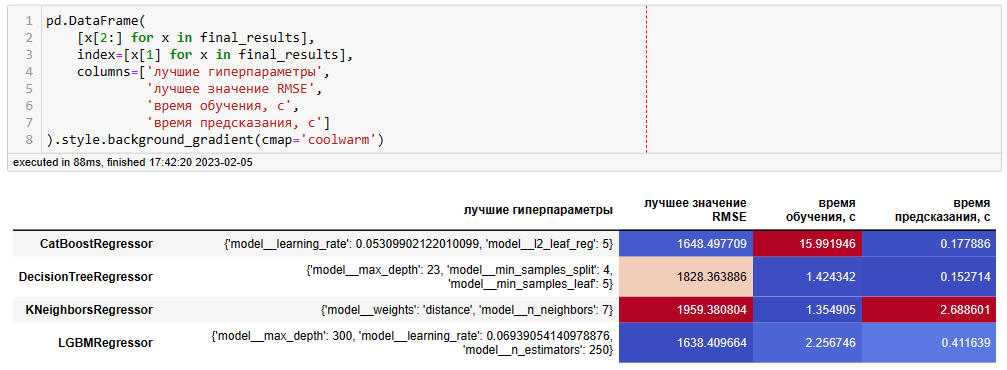

Вычисляем значение метрики на тестовых данных, обучив модель уже на полных данных:

In [34]:
model = final_results[-1][0].best_estimator_.fit(X_train_full, y_train_full)
y_pred = model.predict(X_test)
best_model_rmse = mean_squared_error(y_test, y_pred) ** .5
print('RMSE лучшей модели на тестовой выборке составляет', best_model_rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
RMSE лучшей модели на тестовой выборке составляет 1644.524233639643


Для чистоты эксперимента сравним результаты для простого предсказания среднего на обучающей и валидационной выборке:

In [35]:
baseline_pred = np.full(y_test.shape, y_train_full.mean())
baseline_rmse = mean_squared_error(y_test, baseline_pred) ** .5
print('RMSE baseline модели на тестовой выборке составляет', baseline_rmse)

RMSE baseline модели на тестовой выборке составляет 4600.0597185575425


**Вывод:**

- Лучшая модель с точки соотношения скорость работы и предсказания / точность однозначно LGBMRegressor;
- Модель при обучении на полных данных показывает также отличные результаты и на тесте(трейн - 1638.41, тест - 1644.52), что говорит о достаточной стабильности модели и отсутствии переобучения;
- Модель адекватна, поскольку её метрика превосходит метрику baseline модели.

## Общие выводы

- Данные загружены и изучены, исследованы и обработаны пропуски и аномалии в различных столбцах, удалены некоторые неинформативные признаки, затрагивающие информацию только о продавце, а не автомобиле;
- Данные подготовлены для дальнейшего использования моделями, сформирован пайплайн с помощью которго данные будут преобразованы о потом обучены конкретной моделью;
- Для каждой из 4 рассмотренных моделей проведён подбор гиперпараметров, все модели на кросс-валидации преодолели пороговое значение RMSE 2500.
- Время обучения, время предсказания и качество моделей были собраны в рамках функциии для анализа моделей и собраны в перемнной final_results. 
- Модель, представляющая собой лучший компромисс между качеством модели и скоростью её обучения/предсказания является LGBMRegressor. Она доказала свою стабильность и адекватность на тестовой выборке.
